# Import all packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
# import ROOT as r
from array import array
import matplotlib as mpl
from functools import wraps
import time
import pyarrow.parquet as pq
import pyarrow as pa
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import average_precision_score, matthews_corrcoef, f1_score, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import lightgbm
m_tau = 1.777
m_mu = 0.106
m_numu = 0
m_nutau = 0
L_tot = 5672.
L_snd = 480.


# Preprocessing and visualization functions

In [ ]:

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper
@timeit
def read_files(config_init, read_sep = "  "):
    Data = {}
    for file in config_init:
        Data[file] = pd.read_csv(config_init[file], header = None, sep = read_sep)
        # if file == "tau":
        print(Data[file])
        Data[file].columns = ["Event", "Number", "id", "m_id", "name", "px", "py", "pz", "E", "final", "Xin", "Yin", "Zin"]
        # else:
        #     Data[file].columns = ["Event", "Number", "id", "m_id", "name", 
        #                           "px", "py", "pz", "final", "quark",
        #                           "Xin", "Yin", "Zin",
        #                           "quark_id"]
#         Data[file]["P"] = np.sqrt(Data[file]["px"]**2 + Data[file]["py"]**2 + Data[file]["pz"]**2)
#         Data[file]["E"] = np.sqrt(Data[file]["P"]**2 + pd.Series([m_tau]*len(Data[file]["P"]))**2)
        Data[file]["Rin"] = np.sqrt(Data[file]["Xin"]**2 + Data[file]["Yin"]**2 + Data[file]["Zin"]**2)
#         Data[file]["Theta"] = np.arccos(Data[file]["pz"]/Data[file]["P"])
#         Data[file]["Pt"] = np.sqrt(Data[file]["px"]**2 + Data[file]["py"]**2)
#         Data[file]["Eta"] = -np.log(np.tan(Data[file]["Theta"]/2))
    return Data

def write_parq(Data):
    for part in Data:
        table = pa.Table.from_pandas(Data[part])
        pq.write_table(table, f'{part}_weighted_E.parquet')

@timeit
def read_parq():
    Data_weighted_1 = {}
    keys = ["mu", "tau"]
    for key in keys:
        Data_weighted_1[key] = pq.read_table(f'{key}_weighted_E.parquet').to_pandas()
    return Data_weighted_1


@timeit
def prim_convert(Data):
    mu_weight, tau_weight = pd.read_csv("munu_flux.data", header = None, sep = "\t"), pd.read_csv("taunu_flux.data", header = None, sep = "\t")
    part_list = {"mu": [], "tau": []} 
    weight_temp = 0
    columns_old = list(Data["mu"].columns[:]) + ["weight"]
    for index, row in Data["mu"].iterrows():
#         print(row)
        if row["id"] == 14 and row["m_id"] == -1:
            weight_temp = define_w(row["E"], mu_weight[1].to_list(), mu_weight[0].to_list())
#             print("check")
#         print(weight_temp)
#         if index == 10:
#             break
        part_list["mu"].append(row.to_list() + [weight_temp])
    part_list["mu"] = pd.DataFrame(part_list["mu"])
    part_list["mu"].columns = columns_old

    weight_temp = 0
    fig, ax = plt.subplots(figsize = (6,6), dpi = 150)
    e_dict = {"e_mu": [], "e_nu_mu": [], "e_nu_tau": []}
    for index, row in Data["tau"].iterrows():
        if row["id"] == 16 and row["m_id"] == -1:
            weight_temp = define_w(row["E"], tau_weight[1].to_list(), tau_weight[0].to_list())
        if row["id"] != 15:
            part_list["tau"].append(row.to_list() + [weight_temp])
        else:
            tau_list, nu_mu, nu_tau = setdecay_df_single_3body(row[["px", "py", "pz", "E"]])
            [px, py, pz, E] = tau_list
            e_dict["e_mu"].append(tau_list[-1]), e_dict["e_nu_mu"].append(nu_mu[-1]), e_dict["e_nu_tau"].append(nu_tau[-1])
            P = np.sqrt(px**2 + py**2 + pz**2)
#             Theta = np.arccos(pz/P)
#             Pt = np.sqrt(px**2 + py**2)
#             Eta = -np.log(np.tan(Theta/2))            
            old_part = row[["Event", "Number"]].to_list() + [13, row["m_id"], row["name"]] + tau_list[:-1] + row[["E", "final", "Xin", "Yin", "Zin"]].to_list() + [row["Rin"], weight_temp]
            part_list["tau"].append(old_part)
    part_list["tau"] = pd.DataFrame(part_list["tau"])
    part_list["tau"].columns = list(Data["tau"].columns) + ["weight"]
    
    for e_l in e_dict:
        ax.hist(e_dict[e_l], bins = 150, label = e_l)
    ax.legend()
    ax.set_xlabel("Energy [GeV]")
    ax.set_title("3-body decay kinematics of $\tau \rightarrow \mu\nu\nu$")
    fig.show()
    return part_list, e_dict

@timeit
def prim_convert_numba(Data):
    mu_weight, tau_weight = pd.read_csv("munu_flux.data", header = None, sep = "\t"), pd.read_csv("taunu_flux.data", header = None, sep = "\t")
    part_list = {"mu": [], "tau": []} 
    weight_temp = 0
    columns_old = list(Data["mu"].columns[:]) + ["weight"]
    for index, row in Data["mu"].iterrows():
#         print(row)
        if row["id"] == 14 and row["m_id"] == -1:
            weight_temp = define_w(row["P"], mu_weight[1].to_list(), mu_weight[0].to_list())
#             print("check")
#         print(weight_temp)
#         if index == 10:
#             break
        part_list["mu"].append(row.to_list() + [weight_temp])
    part_list["mu"] = pd.DataFrame(part_list["mu"])
    part_list["mu"].columns = columns_old

    weight_temp = 0
    for index, row in Data["tau"].iterrows():
        if row["id"] == 16 and row["m_id"] == -1:
            weight_temp = define_w(row["P"], tau_weight[1].to_list(), tau_weight[0].to_list())
        if row["id"] != 15:
            part_list["tau"].append(row.to_list() + [weight_temp])
        else:
            tau_list = setdecay_df_single(row[["px", "py", "pz", "E"]])
            [px, py, pz, E] = tau_list
            P = np.sqrt(px**2 + py**2 + pz**2)
            Theta = np.arccos(pz/P)
            Pt = np.sqrt(px**2 + py**2)
            Eta = -np.log(np.tan(Theta/2))            
            old_part = row[["Event", "Number"]].to_list() + [13, row["m_id"], row["name"]] + tau_list[:-1] + row[["final", "Xin", "Yin", "Zin"]].to_list() + [P,E,row["Rin"],Theta, Pt, Eta, weight_temp]
            part_list["tau"].append(old_part)
    part_list["tau"] = pd.DataFrame(part_list["tau"])
    part_list["tau"].columns = list(Data["tau"].columns) + ["weight"]
    return part_list

def setdecay_df_single(data):
    
    tau_lepton = r.TLorentzVector(array('f', data))
    event = r.TGenPhaseSpace()
    event.SetDecay(tau_lepton, 3, np.asarray([m_mu, m_numu, m_nutau]))
    event.Generate()
    muon = event.GetDecay(0)
    return [muon.Vect()[i] for i in range(3)] + [muon.E()]


def setdecay_df_single_3body(data):
    
    tau_lepton = r.TLorentzVector(array('f', data))
    event = r.TGenPhaseSpace()
    event.SetDecay(tau_lepton, 3, np.asarray([m_mu, m_numu, m_nutau]))
    event.Generate()
    return ([event.GetDecay(k).Vect()[i] for i in range(3)] + [event.GetDecay(k).E()] for k in range(3))

def define_w(energy, weight_list, energy_list):
    low, high = 0, len(energy_list) - 1
    def binary_search(a, a_list, low, high):
        if low == high:
            return low
        mid = low + (high - low) // 2
        if a > a_list[mid]:
            return binary_search(a, a_list, mid+1, high)
        else:
            return binary_search(a, a_list, low, mid)
    ind_out = binary_search(energy, energy_list, low, high)
    return weight_list[ind_out]

def dot_prod(df1, df2):
    return df1["px"]*df2["px"] + df1["py"]*df2["py"] + df1["pz"]*df2["pz"]

def plot_stuff(Data):
    fig, ax = plt.subplots(1,2, figsize = (12,6), dpi = 150)
    for part in Data:
        hadron_data = Data[part].query("final == 1 & m_id != 0").groupby("Event").mean()
        muon_data = Data[part].query("final == 1 & m_id == 0 & id == 13")
#         px_had, py_had, pz_had = hadron_data["px"], hadron_data["py"], hadron_data["pz"]
#         px_muon, py_muon, pz_muon = muon_data["px"], muon_data["py"], muon_data["pz"]

        Theta_rel = np.arccos(dot_prod(hadron_data, muon_data)/(np.sqrt(dot_prod(hadron_data, hadron_data))*np.sqrt(dot_prod(muon_data, muon_data))))
        PsinTheta = muon_data["P"]*np.sin(Theta_rel)
        print(PsinTheta)
        ax[0].hist(PsinTheta, bins = 100, weight = muon_data["weight"], histtype = "step", label = f"{part}")
        ax[1].hist(muon_data["Eta"], bins = 100, weight = muon_data["weight"], histtype = "step", label = f"{part}")
        ax[0].set_xlabel("PsinThetanew")
        ax[1].set_xlabel("Muon $\eta$")
        ax[0].legend()
        ax[1].legend()


def hist_2d_correlations_fracs_w_fr(df_muon):
    #t_list = [col for col in df_muon.columns if "/" in col]
    t_list = ["E_mu", "E_hadr/Pt_miss", "E_mu/E_hadr"]
    print(t_list)
    #+ ["anglePtmissandPtmuon", "anglePtmissandPthadr"]
    log_key = True
    for i1 in range(len(t_list)):
        for i2 in range(i1):
            fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=150)
            dfmu = df_muon.query("label == 'numu'")
            dftau = df_muon.query("label == 'nutau'")
            t_1 = t_list[i1]
            t_2 = t_list[i2]
            if "angle" in t_1 or "angle" in t_2:
                log_key = False
            if "miss" in t_1 or "miss" in t_2:
                dfmu = dfmu[dfmu["Pt_miss"] > 1e-4]

            w = dfmu["weight_mu"]
            if log_key:
                bins =   [np.logspace(np.log10(dfmu[t_1].min()), np.log10(dfmu[t_1].max()), 150),
                                    np.logspace(np.log10(dfmu[t_2].min()), np.log10(dfmu[t_2].max()), 150)]
            else:
                bins = 150
            # Plot the 1st histogram
            h1 = ax[0].hist2d(dfmu[t_1], dfmu[t_2],
                              bins=bins,
                              weights=w,
                              norm=mpl.colors.LogNorm())
            ax[0].set_xlabel(t_1)
            ax[0].set_ylabel(t_2)
            if log_key:
                ax[0].set_xscale('log')
                ax[0].set_yscale('log')
            ax[0].set_title('numu')
            
            if log_key:
                bins =   [np.logspace(np.log10(dftau[t_1].min()), np.log10(dftau[t_1].max()), 150),
                                    np.logspace(np.log10(dftau[t_2].min()), np.log10(dftau[t_2].max()), 150)]
            else:
                bins = 150
            # Plot the 2nd histogram
            h2 = ax[1].hist2d(dftau[t_1], dftau[t_2],
                              bins=bins,
                              weights=dftau["weight_mu"],
                              norm=mpl.colors.LogNorm())
            ax[1].set_xlabel(t_1)
            ax[1].set_ylabel(t_2)
            if log_key:
                ax[1].set_xscale('log')
                ax[1].set_yscale('log')
            ax[1].set_title('nutau')

            # Calculate the fraction of bin contents for the 3rd histogram
            fraction = np.divide(h1[0], h2[0], out=np.zeros_like(h1[0]), where=h2[0] != 0)

            # Plot the 3rd histogram with bin contents as fractions
            h3 = ax[2].pcolormesh(h1[1], h1[2], fraction.T, norm=mpl.colors.LogNorm(), shading='auto')
            ax[2].set_xlabel(t_1)
            ax[2].set_ylabel(t_2)
            if log_key:
                ax[2].set_xscale('log')
                ax[2].set_yscale('log')
            ax[2].set_title('numu/nutau fraction')

            # Add colorbar for the 3rd histogram
            cbar = fig.colorbar(h3, ax=ax[2])
            cbar.set_label('Fraction')
            fig.savefig(f"{t_1 if not '/' in t_1 else t_1.replace('/', '-')}_{t_2 if not '/' in t_2 else t_2.replace('/', '-')}_frac.png")
            fig.show()


# Process raw GENIE dataset

In [ ]:
filenames = [f"100k_nu_mu_converted_E", f"100k_nu_tau_converted_E"]
keys = ["mu", "tau"]
config_init = {key: filename for key,filename in zip(keys, filenames)}
Data_0 = read_files(config_init, "\s+")

In [ ]:
Data_conv_1, e_dict = prim_convert(Data_0)

In [ ]:
import matplotlib as mpl
fig, ax = plt.subplots(1,3, figsize = (18,6), dpi = 150)
h = ax[0].hist2d(e_dict["e_mu"], e_dict["e_nu_mu"], bins = 150, norm=mpl.colors.LogNorm())
ax[0].set_xlabel("E_mu [GeV]")
ax[0].set_ylabel("E_nu_mu [GeV]")
fig.colorbar(h[3], ax = ax[0])
h = ax[1].hist2d(e_dict["e_mu"], e_dict["e_nu_tau"], bins = 150, norm=mpl.colors.LogNorm())
ax[1].set_xlabel("E_mu [GeV]")
ax[1].set_ylabel("E_nu_tau [GeV]")
fig.colorbar(h[3], ax = ax[1])
h = ax[2].hist2d(e_dict["e_nu_mu"], e_dict["e_nu_tau"], bins = 150, norm=mpl.colors.LogNorm())
ax[2].set_xlabel("E_nu_mu [GeV]")
ax[2].set_ylabel("E_nu_tau [GeV]")
fig.colorbar(h[3], ax = ax[2])
fig.show()

In [ ]:
write_parq(Data_conv_1)

In [3]:
Data = read_parq()

Function read_parq() {} Took 1.0655 seconds


In [135]:
df_muon

,Number_mu,id_mu,m_id_mu,px_mu,py_mu,pz_mu,E_mu,final_mu,Xin_mu,Yin_mu,...,E_mu/E_hadr,Pt_mu/Pt_hadr,E_mu/Pt_miss,E_hadr/Pt_miss,Pt_hadr/Pt_miss,E_hadr/E_mu,Pt_hadr/Pt_mu,anglePtmissandPtmuon,anglePtmissandPthadr,Pt_mu_on_Pt_miss
0,4,13,0,-0.395335,1.410480,4.122980,4.37674,1,-3.114130,-2.370250,...,0.093980,2.009629,5.895469,62.730785,0.981840,10.640508,0.497604,3.048684,0.187542,-1.458518
1,4,13,0,-0.823244,-1.713570,4.449670,4.83992,1,-3.299080,1.204300,...,0.294799,3.950544,3.370942,11.434719,0.335161,3.392143,0.253130,3.067259,0.297767,-1.895817
2,4,13,0,2.298400,-3.231520,87.293700,87.38380,1,-0.706313,1.873840,...,1.128487,1.042492,71.050874,62.961198,3.092900,0.886142,0.959240,1.858570,1.598243,-1.125485
3,4,13,0,-2.412260,-0.624049,13.124100,13.35900,1,5.401330,1.794800,...,0.593453,0.915822,40.157392,67.667384,8.178461,1.685054,1.091915,0.858820,2.375474,1.627887
4,4,13,0,0.522271,1.370760,17.380000,17.44210,1,1.939440,-1.959690,...,5.033136,1.056958,69.628750,13.834070,5.540234,0.198683,0.946112,1.974082,1.334301,-0.575668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,4,13,0,-0.253284,1.447580,38.710466,105.40900,1,1.002820,-2.373310,...,4.344584,0.835030,357.282817,82.236370,5.965174,0.230172,1.197562,0.195737,2.978465,1.441509
199996,4,13,0,-0.887361,-0.168192,5.071169,28.57020,1,3.876700,2.288130,...,8.238038,0.649310,41.081763,4.986838,2.000084,0.121388,1.540096,1.040468,2.547060,0.456833
199997,4,13,0,-0.632842,-1.073515,36.417173,41.49860,1,-0.439113,-0.916629,...,1.774250,0.600377,47.447281,26.742160,2.373172,0.563618,1.665621,0.420029,2.894253,1.137843
199998,4,13,0,0.454588,-0.106785,11.348304,93.36870,1,0.233667,3.843610,...,2.055343,0.195053,41.202353,20.046460,1.056450,0.486537,5.126811,1.391187,2.948479,0.083420


# Calculate the parameters for classification

In [3]:
Data = read_parq()
neutrals = ["pi0", "neutron", "gamma", 'K0', 'K0_bar', 'K_L0', 'Lambda0', 'Lambda0_bar', "antineutron", 'nu_e_bar']
neutrals = ["pi0","neutron", "antineutron", 'nu_e_bar', 'K0', 'K0_bar', 'K_L0', 'HardBlob']
muon_data_numu = Data["mu"].query("final == 1 & m_id == 0 & id == 13").copy().set_index("Event").drop(columns = ["name"])
hadron_data_numu = Data["mu"].loc[~Data["mu"].name.isin(neutrals)].query("final == 1 & m_id != 0").drop(columns = ["name"]).groupby("Event").sum()
muon_data_numu.columns = [col + "_mu" for col in muon_data_numu.columns]
hadron_data_numu.columns = [col + "_hadr" for col in hadron_data_numu.columns]
nu_data_numu = pd.DataFrame(Data["mu"].query("m_id == -1 & id == 14")["pz"])
nu_data_numu.columns = ["P_nu"]
muon_data_numu = pd.concat([muon_data_numu, hadron_data_numu], axis = 1)
#print(muon_data_numu)
muon_data_numu["label"] = pd.Series(len(muon_data_numu["id_mu"])*["numu"])
muon_data_nutau = Data["tau"].query("final == 1 & m_id == 0 & id == 13").copy().set_index("Event").drop(columns = ["name"])
hadron_data_nutau = Data["tau"].loc[~Data["tau"].name.isin(neutrals)].query("final == 1 & m_id != 0").drop(columns = ["name"]).groupby("Event").sum()
muon_data_nutau.columns = [col + "_mu" for col in muon_data_nutau.columns]
hadron_data_nutau.columns = [col + "_hadr" for col in hadron_data_nutau.columns]
nu_data_nutau = pd.DataFrame(Data["tau"].query("m_id == -1 & id == 16")["pz"])
nu_data_nutau.columns = ["P_nu"]
muon_data_nutau = pd.concat([muon_data_nutau, hadron_data_nutau], axis = 1)
muon_data_nutau["label"] = pd.Series(len(muon_data_nutau["id_mu"])*["nutau"])
df_muon = pd.concat([muon_data_numu, muon_data_nutau], ignore_index = True)
df_muon["px_miss"] = -df_muon["px_mu"].values - df_muon["px_hadr"].values
df_muon["py_miss"] = -df_muon["py_mu"].values - df_muon["py_hadr"].values
#df_muon["pz_miss"] = df_muon["P_nu"].values - df_muon["pz_mu"].values - df_muon["pz_hadr"].values
#df_muon["P_miss"] = np.sqrt(df_muon["px_miss"]**2 + df_muon["py_miss"]**2 + df_muon["pz_miss"]**2)
df_muon["Pt_miss"] = np.sqrt(df_muon["px_miss"]**2 + df_muon["py_miss"]**2)
df_muon["Pt_mu"] = np.sqrt(df_muon["px_mu"]**2 + df_muon["py_mu"]**2)
df_muon["P_mu"] = np.sqrt(df_muon["px_mu"]**2 + df_muon["py_mu"]**2 + df_muon["pz_mu"]**2)
df_muon["Pt_hadr"] = np.sqrt(df_muon["px_hadr"]**2 + df_muon["py_hadr"]**2)
df_muon["P_hadr"] = np.sqrt(df_muon["px_hadr"]**2 + df_muon["py_hadr"]**2 + df_muon["pz_hadr"]**2)
df_muon["Pt_miss/E_mu"] = df_muon["Pt_miss"]/df_muon["E_mu"]
df_muon["Pt_miss/E_hadr"] = df_muon["Pt_miss"]/df_muon["E_hadr"]
df_muon["Pt_miss/Pt_mu"] = df_muon["Pt_miss"]/df_muon["Pt_mu"]
df_muon["Pt_miss/Pt_hadr"] = df_muon["Pt_miss"]/df_muon["Pt_hadr"]
df_muon["E_mu/E_hadr"] = df_muon["E_mu"]/df_muon["E_hadr"]
df_muon["Pt_mu/Pt_hadr"] = df_muon["Pt_mu"]/df_muon["Pt_hadr"]

df_muon["E_mu/Pt_miss"] = df_muon["E_mu"]/df_muon["Pt_miss"]
df_muon["E_hadr/Pt_miss"] = df_muon["E_hadr"]/df_muon["Pt_miss"]
df_muon["Pt_miss/Pt_mu"] = df_muon["Pt_miss"]/df_muon["Pt_mu"]
df_muon["Pt_hadr/Pt_miss"] = df_muon["Pt_hadr"]/df_muon["Pt_miss"]
df_muon["E_hadr/E_mu"] = df_muon["E_hadr"]/df_muon["E_mu"]
df_muon["Pt_hadr/Pt_mu"] = df_muon["Pt_hadr"]/df_muon["Pt_mu"]

df_muon["anglePtmissandPtmuon"] = np.arccos((df_muon["px_miss"]*df_muon["px_mu"] + df_muon["py_miss"]*df_muon["py_mu"])/(df_muon["Pt_miss"]*df_muon["Pt_mu"]))
df_muon["anglePtmissandPthadr"] = np.arccos((df_muon["px_miss"]*df_muon["px_hadr"] + df_muon["py_miss"]*df_muon["py_hadr"])/(df_muon["Pt_miss"]*df_muon["Pt_hadr"]))
df_muon["Pt_mu_on_Pt_miss"] = (df_muon["px_miss"]*df_muon["px_mu"] + df_muon["py_miss"]*df_muon["py_mu"])/df_muon["Pt_miss"]
# df_muon = df_muon.dropna()
# y = df_muon["label"].values
# weights = df_muon["weight_mu"].values
# excl_list = ["Number", "id", "m_id", "final", "Xin", "Yin", "Zin", "Rin", "weight", "label"]
# excl_list = [col + "_mu" for col in excl_list[:-1]] + [col + "_hadr" for col in excl_list[:-1]] + ["label"]
# df_muon = df_muon.drop(columns = excl_list)

Function read_parq() {} Took 0.9854 seconds


In [4]:
df_muon_1 = df_muon.dropna()
X = df_muon_1.loc[:, ~df_muon_1.columns.isin(['Number_mu', 'id_mu', 'm_id_mu', 'final_mu', 'Xin_mu', 'Yin_mu', 'Zin_mu', 'Rin_mu', 'weight_mu',
       'Number_hadr', 'id_hadr', 'm_id_hadr', 'final_hadr', 'Xin_hadr', 'Yin_hadr', 'Zin_hadr', 'Rin_hadr',
       'weight_hadr', 'label'])]
y = df_muon_1["label"]

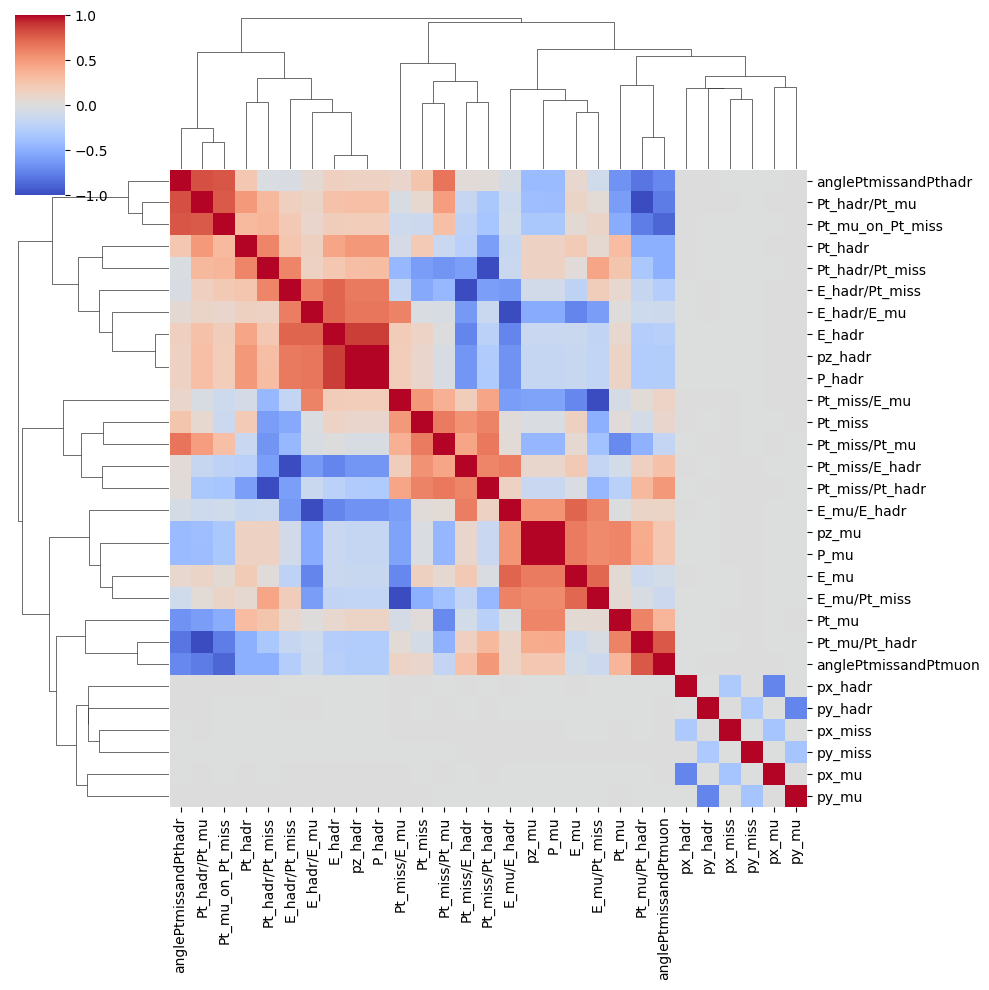

In [118]:
import seaborn as sns
corr_matrix = X.corr(method='spearman')
# fig, ax1 = plt.subplots(figsize = (8,8), dpi = 200)
res = sns.clustermap(corr_matrix, method='weighted', cmap='coolwarm')
plt.savefig('corr_matrix_0.pdf', format='pdf')

['E_mu', 'E_hadr/Pt_miss', 'E_mu/E_hadr']


/var/folders/8q/10g2kvdx0d71nvvyj7xyg2l40000gn/T/ipykernel_41091/448242833.py:74: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/var/folders/8q/10g2kvdx0d71nvvyj7xyg2l40000gn/T/ipykernel_41091/448242833.py:74: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/var/folders/8q/10g2kvdx0d71nvvyj7xyg2l40000gn/T/ipykernel_41091/448242833.py:74: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



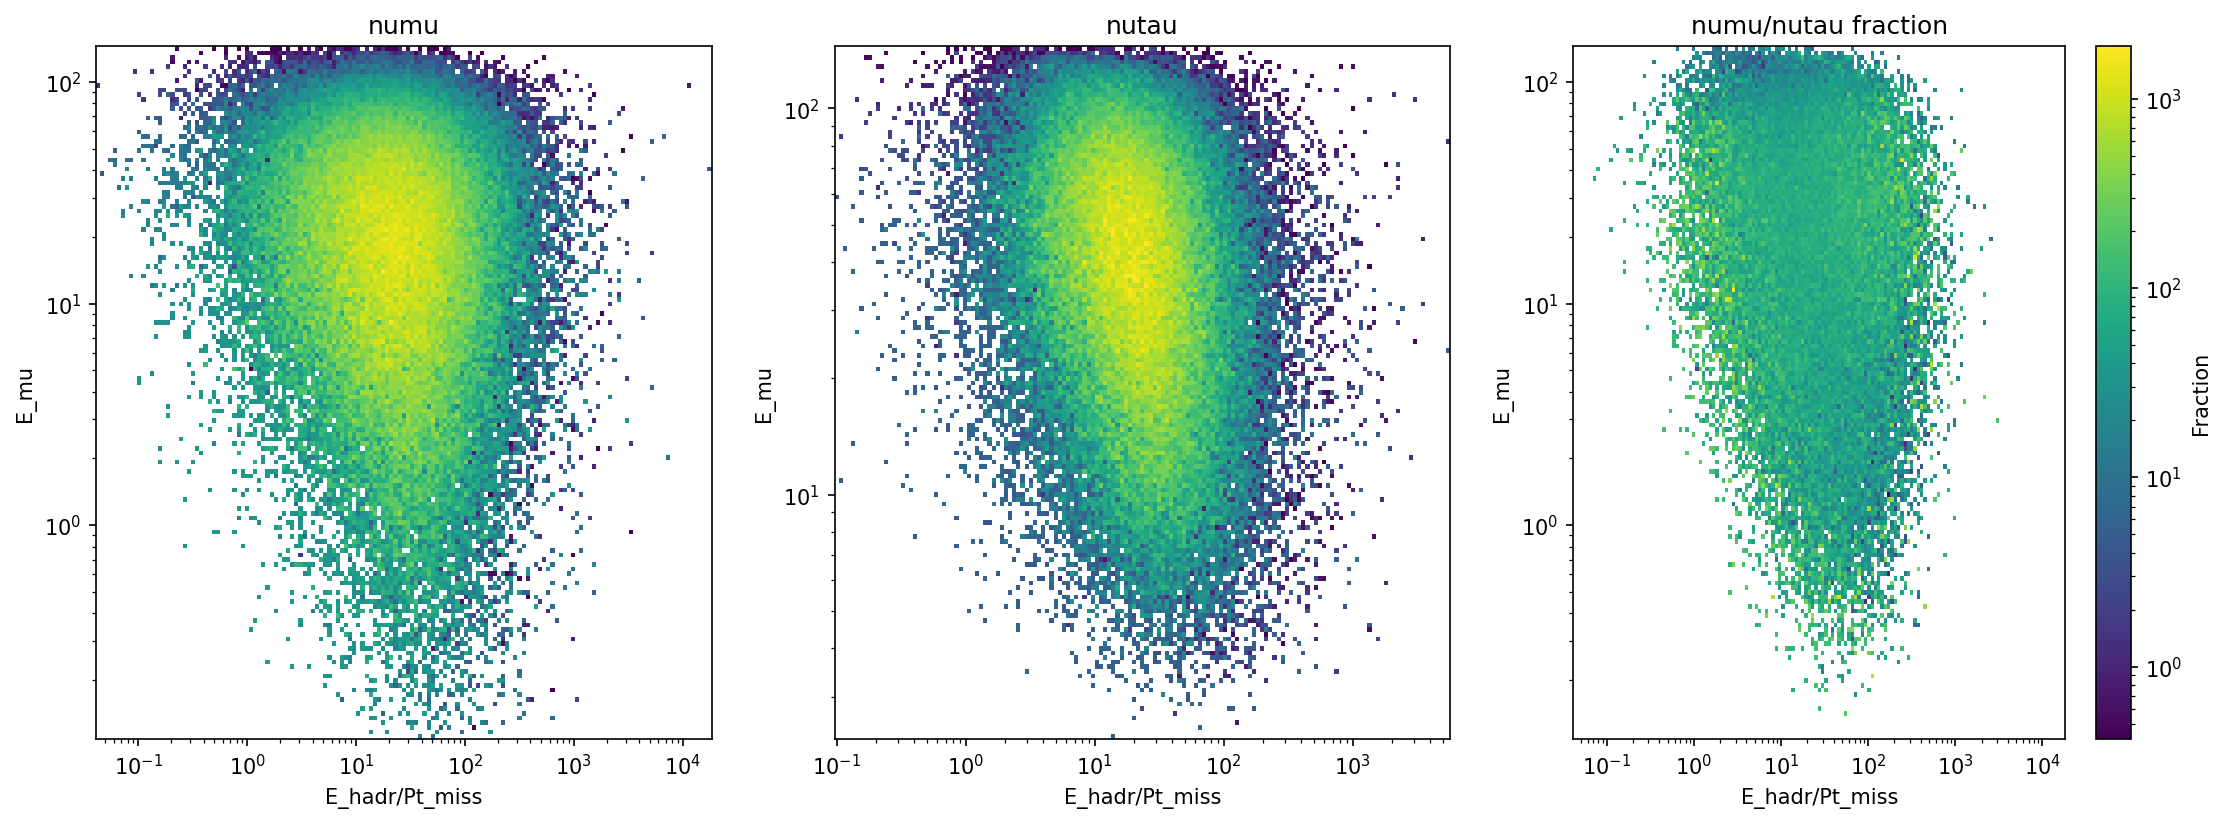

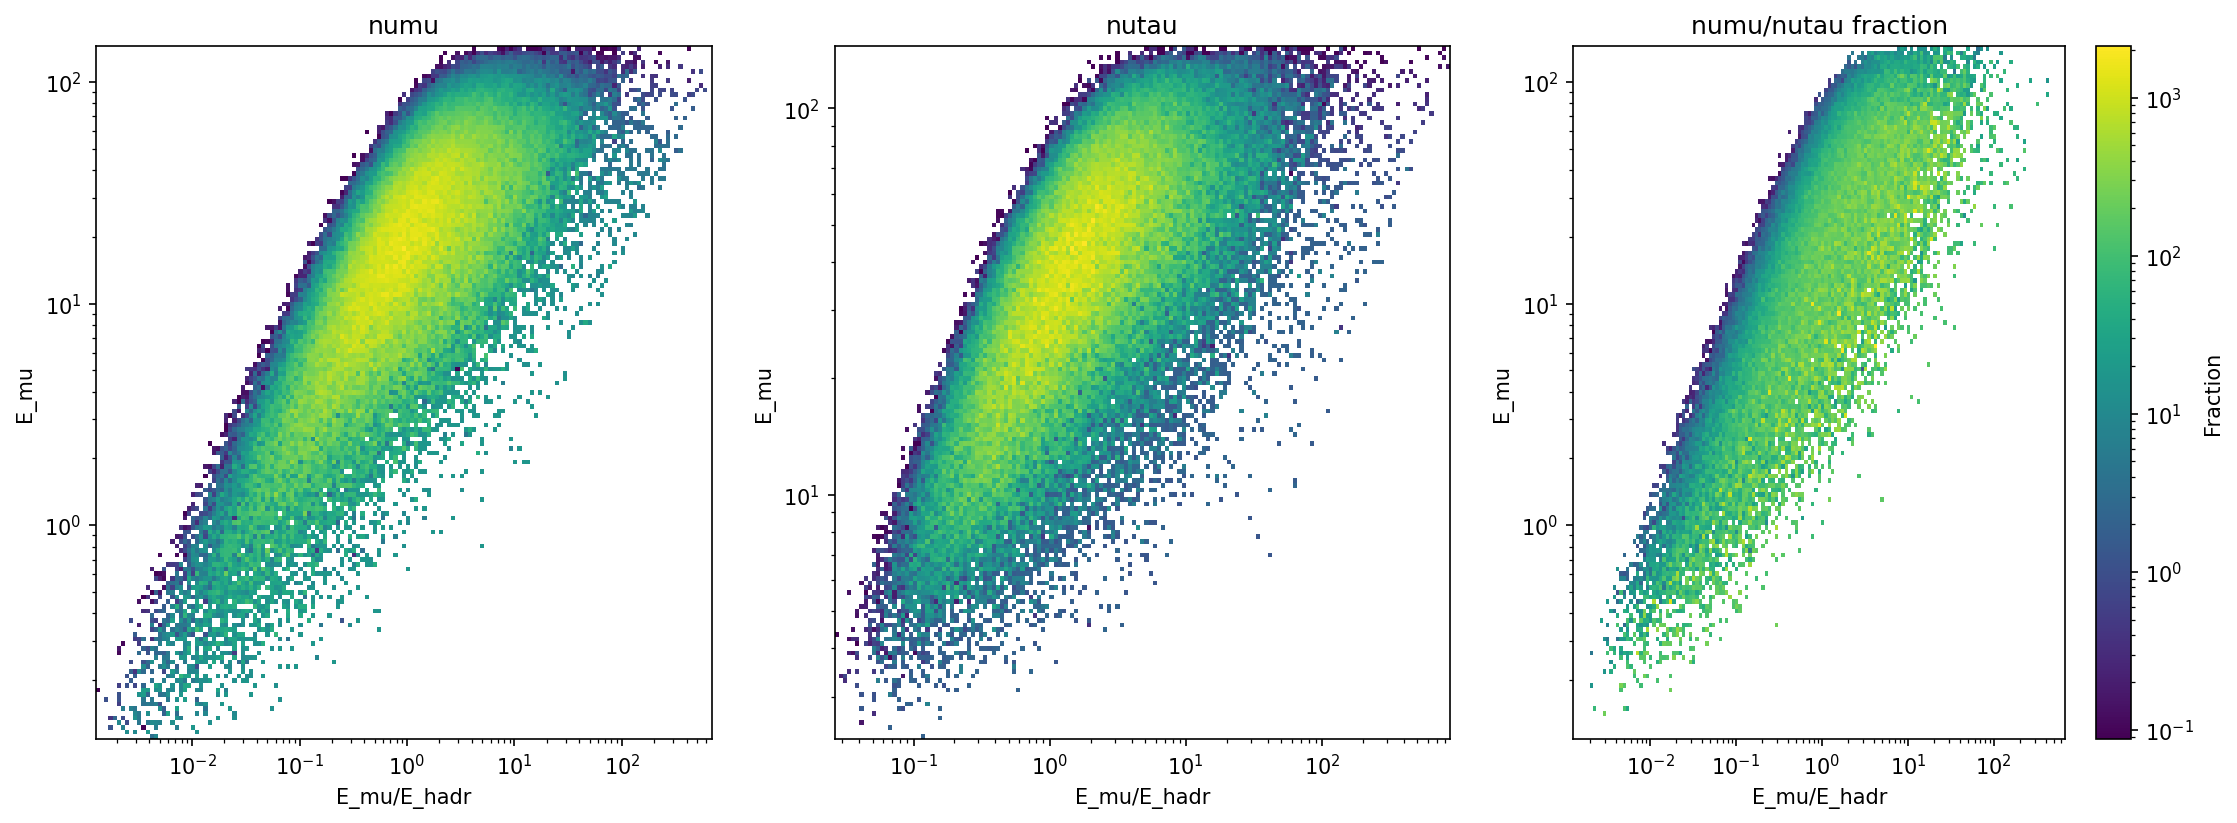

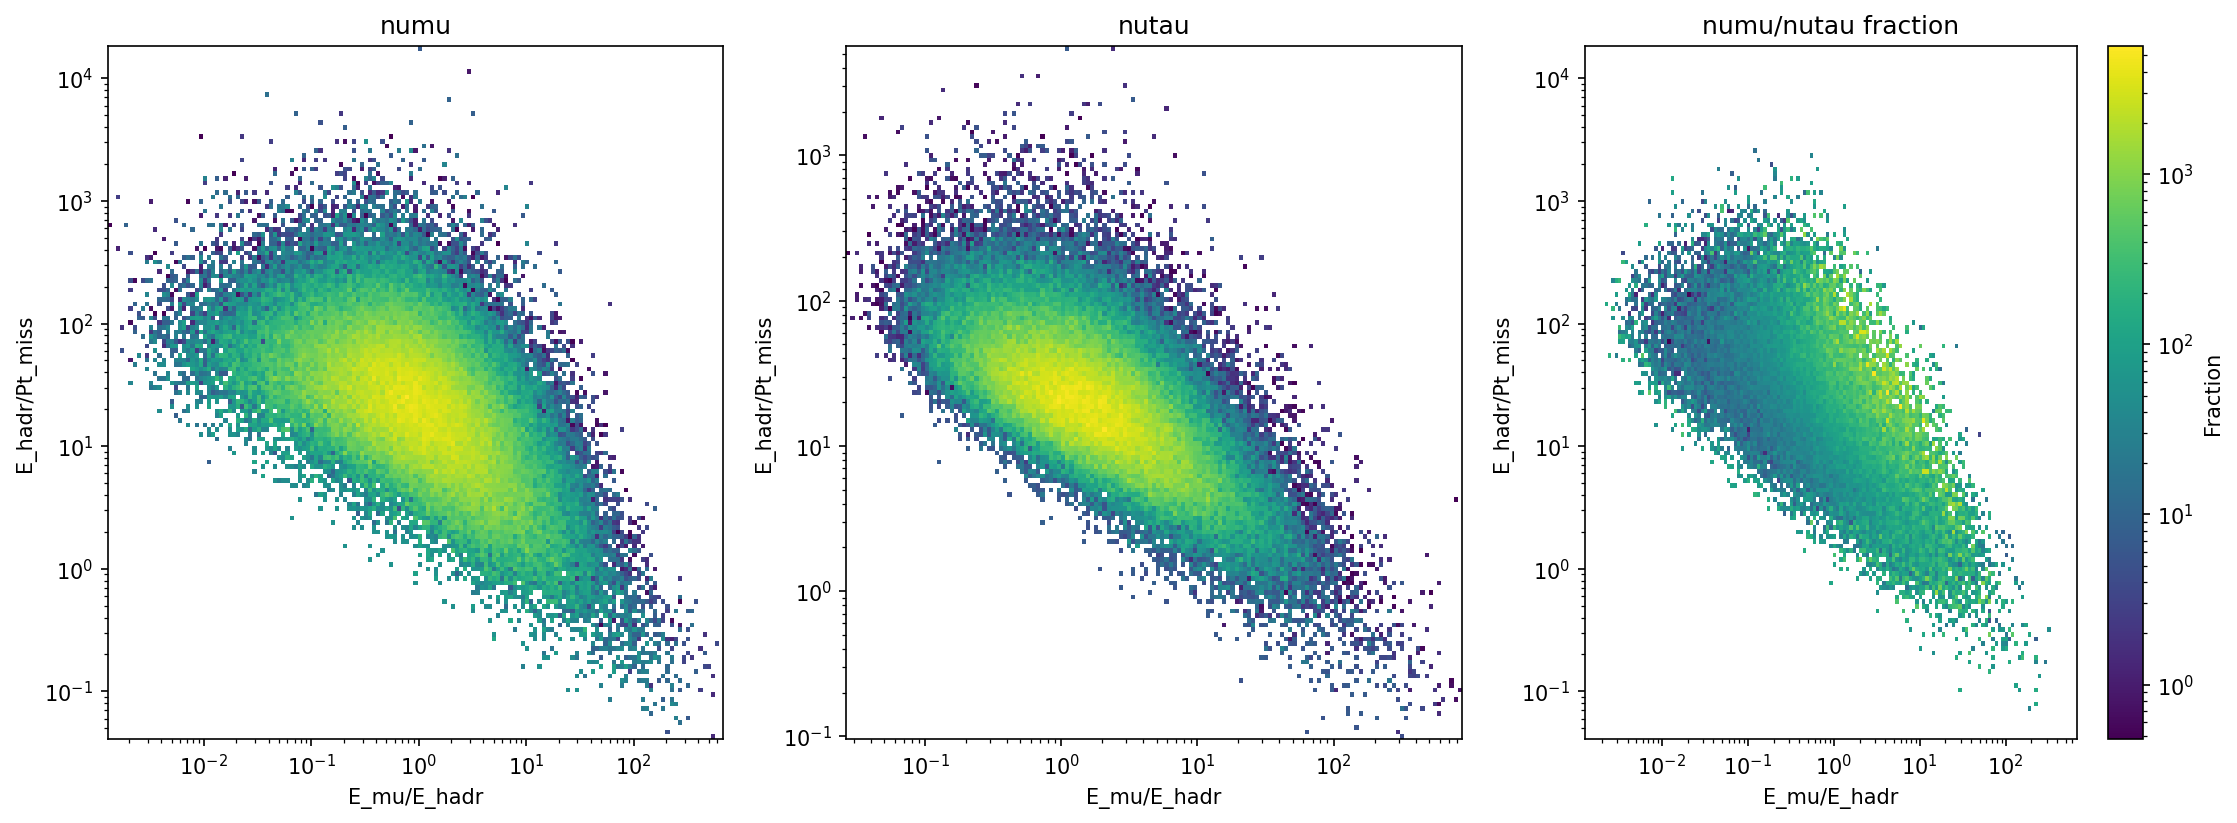

In [136]:
# Call the function
hist_2d_correlations_fracs_w_fr(df_muon)

In [12]:
X.columns

Index(['px_mu', 'py_mu', 'pz_mu', 'E_mu', 'px_hadr', 'py_hadr', 'pz_hadr',
       'E_hadr', 'px_miss', 'py_miss', 'Pt_miss', 'Pt_mu', 'P_mu', 'Pt_hadr',
       'P_hadr', 'Pt_miss/E_mu', 'Pt_miss/E_hadr', 'Pt_miss/Pt_mu',
       'Pt_miss/Pt_hadr', 'E_mu/E_hadr', 'Pt_mu/Pt_hadr', 'E_mu/Pt_miss',
       'E_hadr/Pt_miss', 'Pt_hadr/Pt_miss', 'E_hadr/E_mu', 'Pt_hadr/Pt_mu',
       'anglePtmissandPtmuon', 'anglePtmissandPthadr', 'Pt_mu_on_Pt_miss'],
      dtype='object')

In [30]:
X.values[:,0].size, df_muon_1['weight_mu'].values.size
np.hstack(())

(199991, 199991)

In [78]:
X.shape

(199974, 29)

# PCA and traing BDT

In [5]:
pca = PCA(n_components=20).set_output(transform = "pandas")

preproc = pca
X_pca = preproc.fit_transform(X)
X_pca = np.hstack((X_pca, df_muon_1['weight_mu'].values.reshape(-1, 1)))

In [81]:
pca

PCA(n_components=20)

In [91]:
df_muon_1["label"].map({'numu':0,'nutau':1}).values

array([0, 0, 0, ..., 1, 1, 1])

In [6]:
from sklearn.ensemble import RandomForestClassifier
# scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, df_muon_1["label"].map({'numu':0,'nutau':1}).values, random_state=13,  shuffle=True
)

# scaler = StandardScaler()

weights_train = X_train[:,-1]
X_train = X_train[:,:-1]
#X_train = preproc.fit_transform(X_train[:,:-1])

# X_train = scaler.fit_transform(X_train[:,:-1])
# rf = RandomForestClassifier()
rf = lightgbm.LGBMClassifier()
rf.fit(X_train, y_train,
       sample_weight = weights_train,
       feature_name=[f"PC {i}" for i in range(1,21)]
      )
weights_test = X_test[:,-1]
X_test = X_test[:,:-1]
# X_test = preproc.fit_transform(X_test[:,:-1])
# X_test = scaler.fit_transform(X_test[:,:-1])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 74861, number of negative: 75119
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 149980, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013479 -> initscore=-4.293016
[LightGBM] [Info] Start training from score -4.293016


# Testing performance

In [7]:
# f1 score. Bootstrap
def bootstrap_metric(x, 
                     y,
                     w,
                     metric_fn,
                     samples_cnt = 100,
                     alpha = 0.05,
                     random_state = 42):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        w_boot = w[poses]
        
        m_val = metric_fn(x_boot, y_boot, w_boot)
        b_metric[it] = m_val
        if it%10 == 0:
            print(it, "...")
    
    return b_metric
alpha = 0.05
y_pred = rf.predict(X_test)
cor = accuracy_score(y_test, y_pred)
boot_mat_score = bootstrap_metric(y_test, y_pred, weights_test, metric_fn=lambda x, y, w: f1_score(y_true=x, y_pred=y, sample_weight=w) , alpha = alpha)
print("Model: {0}".format("Random Forest"), " \t f1-score: ", np.quantile(boot_mat_score, q=[alpha/2, 1 - alpha/2]))



0 ...
10 ...
20 ...
30 ...
40 ...
50 ...
60 ...
70 ...
80 ...
90 ...
Model: Random Forest  	 f1-score:  [0.93893864 0.97668653]


In [75]:
pca.components_.T.shape

(20, 20)

E_mu             0.754168
E_mu/E_hadr      0.183243
Pt_hadr/Pt_mu    0.117621
Name: PC 5, dtype: float64 
 E_hadr/Pt_miss    0.891150
E_hadr            0.127026
pz_hadr           0.114178
Name: PC 2, dtype: float64 
 E_mu/E_hadr    0.964257
E_hadr/E_mu    0.123618
pz_hadr        0.085756
Name: PC 6, dtype: float64 
 E_hadr/Pt_miss     0.154594
E_mu/E_hadr        0.059691
Pt_hadr/Pt_miss    0.014143
Name: PC 4, dtype: float64


NameError: name 'prepare_formula' is not defined

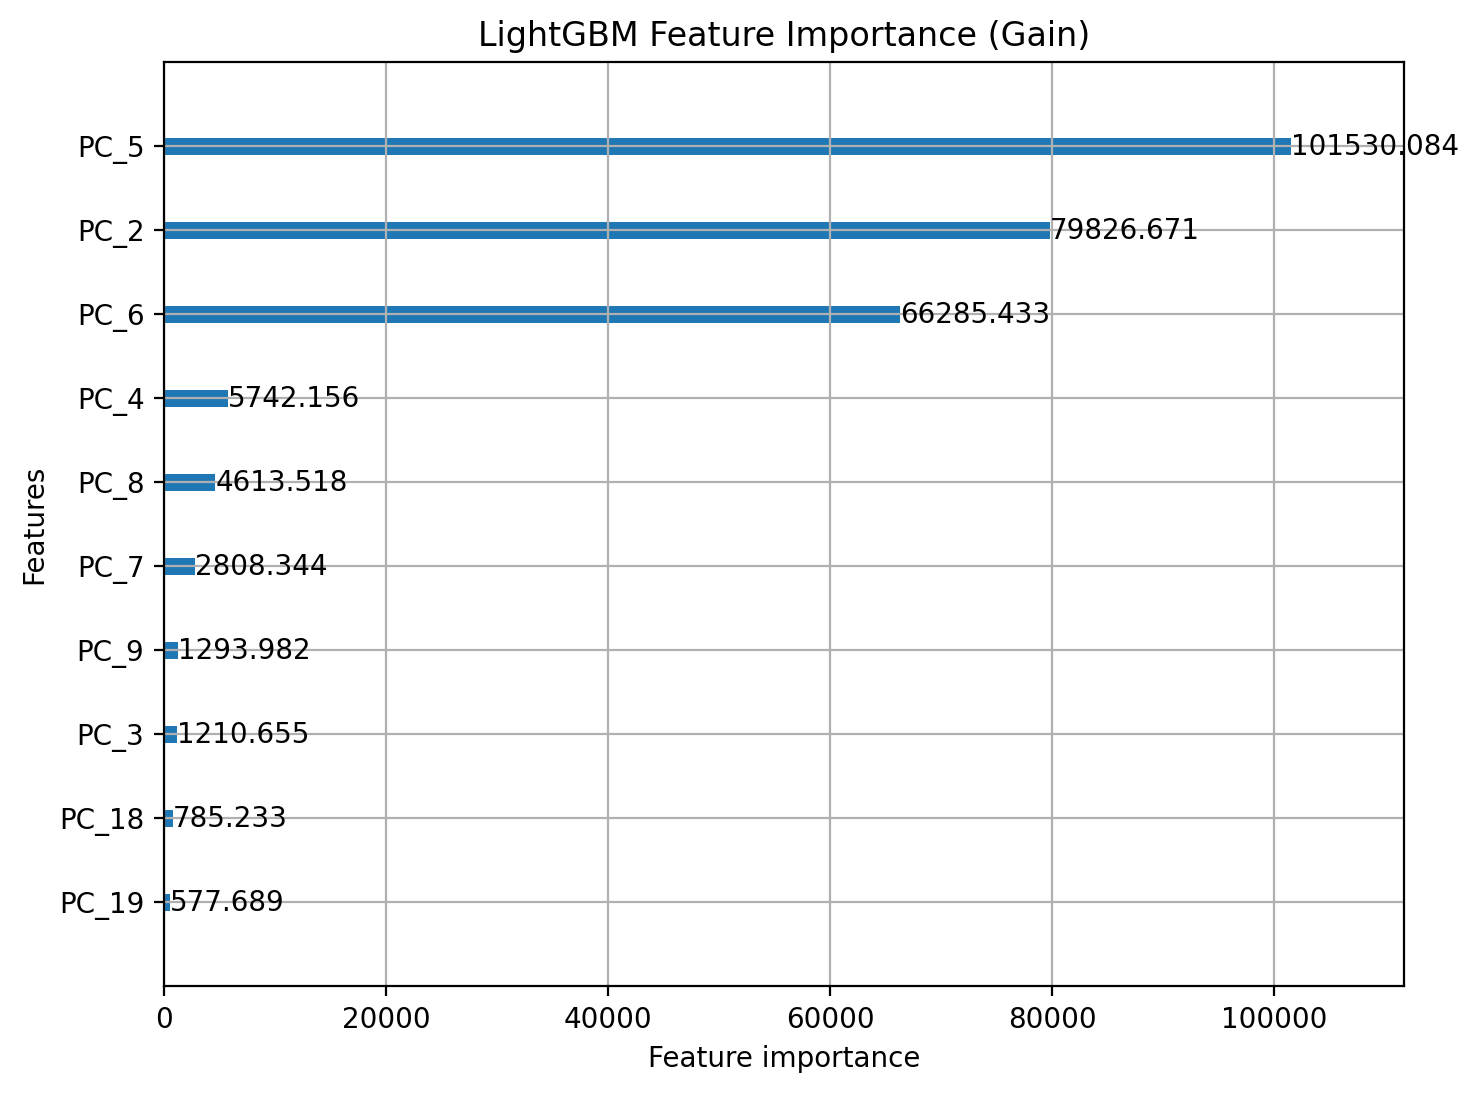

In [8]:
# Plot feature importance using Gain
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
lightgbm.plot_importance(rf, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)", max_num_features=10, ax = ax)
def prepare_formula(var, top_three_values_pc):
    var_names = list(map(str, top_three_values_pc.index))
    var_vals = top_three_values_pc.to_numpy()
    output_str = var + "="
    k = 0
    for val, name in zip(var_vals, var_names):
        output_str += f"{val:.2f}*{name}"
        if k != 2:
            output_str += "+"
        k += 1 
    return output_str
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC {i + 1}' for i in range(pca.n_components_)], index=X.columns)
par1 = "PC 5"
par2 = "PC 2"
par3 = "PC 6"
par4 = "PC 4"
top_three_values_pc1 = loadings.nlargest(3, "PC 5")["PC 5"]
top_three_values_pc2 = loadings.nlargest(3, "PC 2")["PC 2"]
top_three_values_pc3 = loadings.nlargest(3, "PC 6")["PC 6"]
top_three_values_pc4 = loadings.nlargest(3, "PC 4")["PC 4"]
print(top_three_values_pc1, "\n", top_three_values_pc2, "\n", top_three_values_pc3, "\n", top_three_values_pc4)
str_out = prepare_formula(par1, top_three_values_pc1) + "\n" + prepare_formula(par2, top_three_values_pc2) + "\n" + \
             prepare_formula(par3, top_three_values_pc3) + "\n" + prepare_formula(par4, top_three_values_pc4)


ax.text(0.15, 0.05, str_out, transform=ax.transAxes, fontsize=11, verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))
fig.savefig("importance.pdf")
fig.show()

In [42]:
#rf.score(X_test, y_test, weights_test)
# print the scores on training and test set

print('Training set score: {:.4f}'.format(rf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(rf.score(X_test, y_test)))

Training set score: 0.9947
Test set score: 0.9616


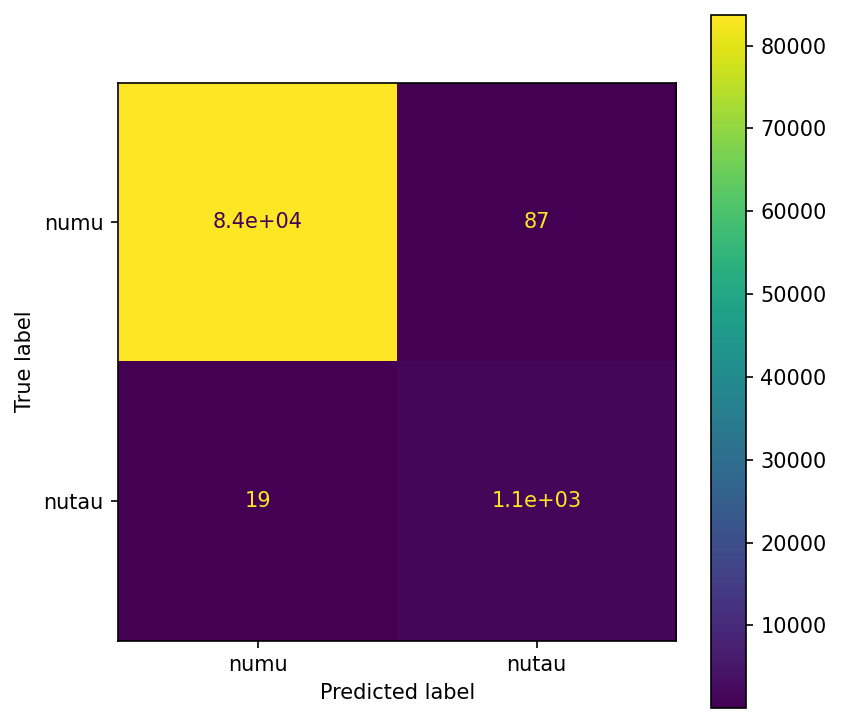

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test and y_pred are your target and predicted labels, and weights_test are your sample weights
cm = confusion_matrix(y_test, y_pred, sample_weight=weights_test)

# Define the tick labels
tick_labels = ["numu", "nutau"]

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
display = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
display.plot(ax=ax)

# Set tick labels
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)
fig.savefig("conf_matrix_labeled.pdf")
plt.show()


In [235]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

cross_val_metrics = ["accuracy"]
                     #"f1", "matthews_corrcoef", "recall", "precision"]

# cross_val_metrics_1 = {key: make_scorer(eval(key)) for key in cross_val_metrics}
cross_val_metrics_vals = {key: [] for key in cross_val_metrics}

X_check_feat = np.hstack((X, df_muon_1['weight_mu'].values.reshape(-1, 1)))
X_train, X_test, y_train, y_test = train_test_split(
    X_check_feat, df_muon_1["label"].map({'numu':0,'nutau':1}).values, random_state=13,  shuffle=True
)
for i in range(1, X.columns.size+1):
    pca = PCA(n_components=i).set_output(transform = "pandas")
    model = lightgbm.LGBMClassifier()
    weights_train = X_train[:,-1]
    X_train_1 = X_train[:,:-1]
    X_train_reduced = pca.fit_transform(X_train_1)
    model.fit(X_train_reduced, y_train, sample_weight = weights_train) 
    for key in cross_val_metrics_vals:
        scores = cross_val_score(model, X_train_reduced, y_train, cv=5, scoring = key, fit_params = {"sample_weight": weights_train})
        cross_val_metrics_vals[key].append(scores.mean())
    # cross_val.append(scores.mean())
    # cross_err.append(scores.std())
    #print(f"{i} first components", model.score(X_test_reduced,y_test))

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/lightgbm/basic.py:599: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


[LightGBM] [Info] Number of positive: 74861, number of negative: 75119
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 149980, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013479 -> initscore=-4.293016
[LightGBM] [Info] Start training from score -4.293016


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM] [In

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM] [In

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[Lig

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 4
[LightGBM] [Info] 

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 5
[LightGBM] [Info] 

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 6
[LightGBM] [Info] 

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[L

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 8
[LightGBM] [Info] 

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[L

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 11
[LightGBM] [Info

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 13
[LightGBM] [Info

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM]

/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013487 -> initscore=-4.292453
[LightGBM] [Info] Start training from score -4.292453
[LightGBM] [Info] Number of positive: 59889, number of negative: 60095
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 119984, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013454 -> initscore=-4.294957
[LightGBM] [Info] Start training from score -4.294957
[LightGBM]

Text(0, 0.5, 'accuracy')

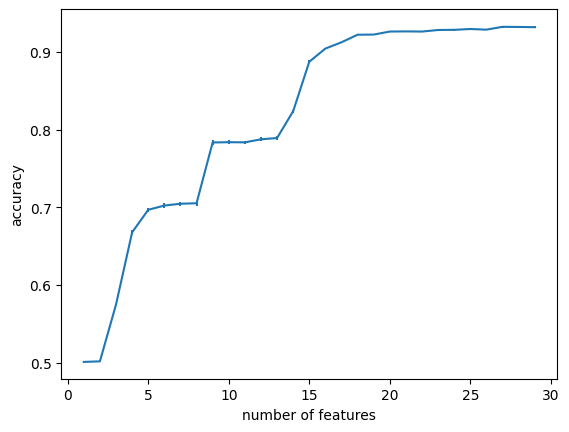

In [200]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(1, X.columns.size+1),
         cross_val, 
         yerr=cross_err)
#plt.xlim((0,20))
# ax.set_title(f"Wall 3")
ax.set_xlabel("number of features")
ax.set_ylabel("accuracy")

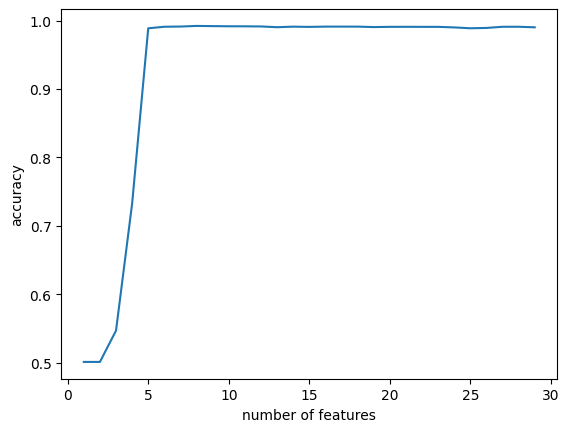

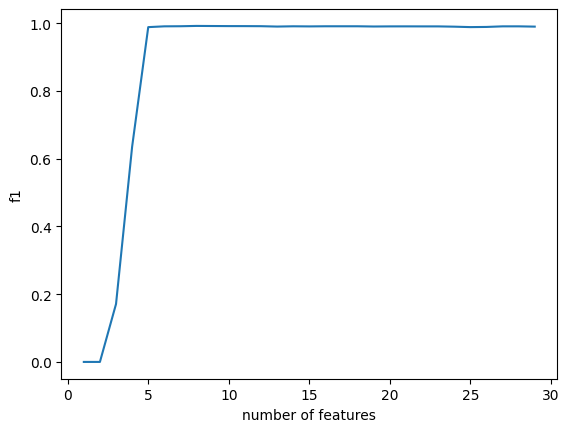

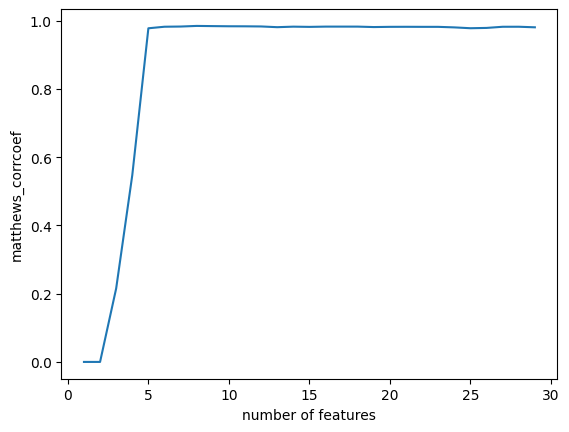

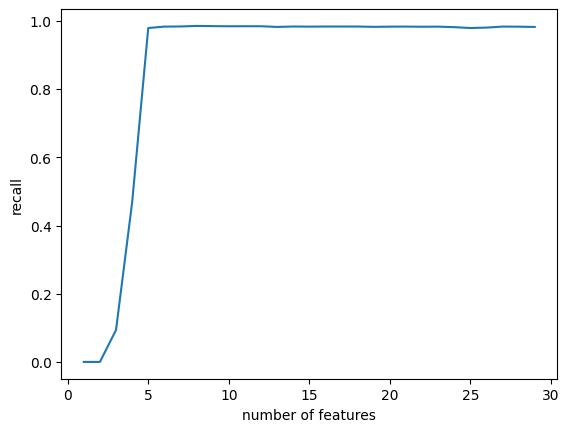

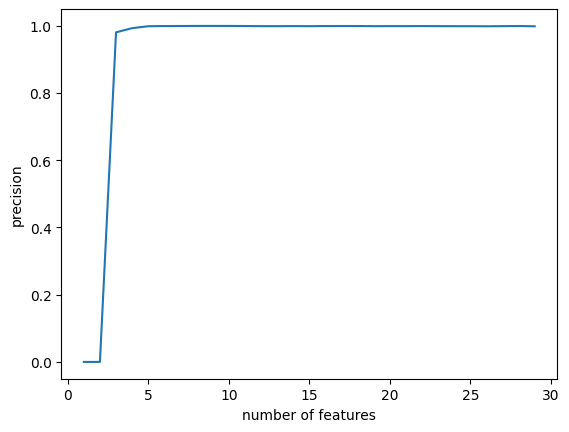

In [230]:
for key in cross_val_metrics_vals:
    fig, ax = plt.subplots()
    ax.errorbar(np.arange(1, X.columns.size+1),
             cross_val_metrics_vals[key])
    #plt.xlim((0,20))
    # ax.set_title(f"Wall 3")
    ax.set_xlabel("number of features")
    ax.set_ylabel(key)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24866
           1       1.00      0.98      0.99     25128

    accuracy                           0.99     49994
   macro avg       0.99      0.99      0.99     49994
weighted avg       0.99      0.99      0.99     49994



In [53]:
X_test_shap = pd.DataFrame({f"PC {i+1}": X_test[:,i] for i in range(20)})
%time shap_values = shap.TreeExplainer(rf).shap_values(X_test_shap)


CPU times: user 24.9 s, sys: 188 ms, total: 25.1 s
Wall time: 3.76 s


/Users/eduard/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



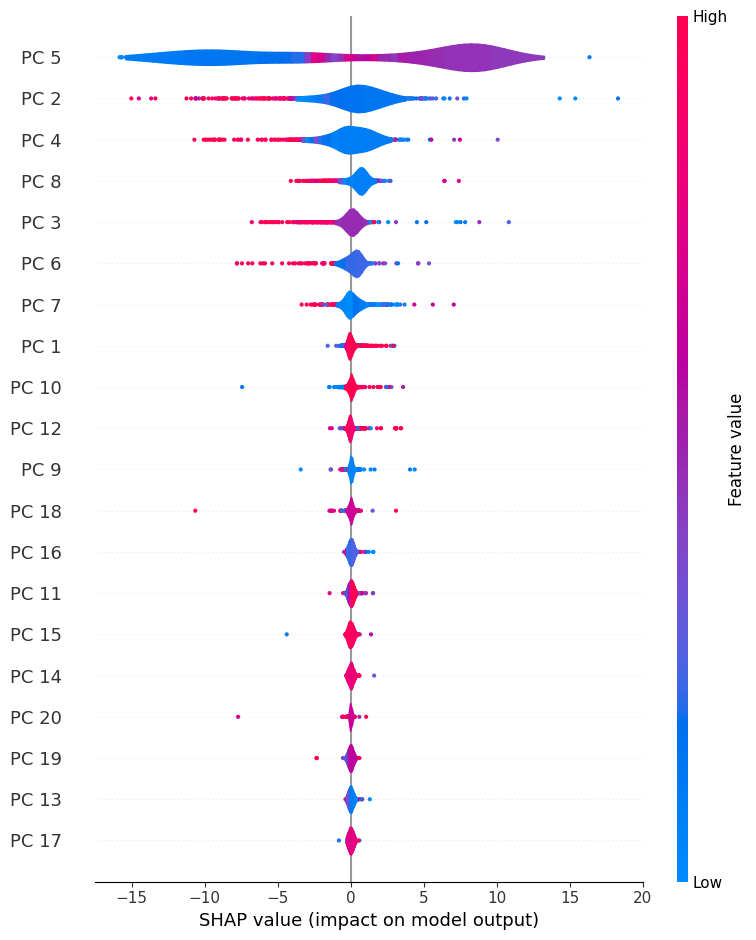

In [62]:
shap.initjs()
shap.summary_plot(shap_values[:1000,:], X_test_shap.iloc[:1000,:], plot_type="violin")

100%|===================| 49811/49994 [01:48<00:00]        

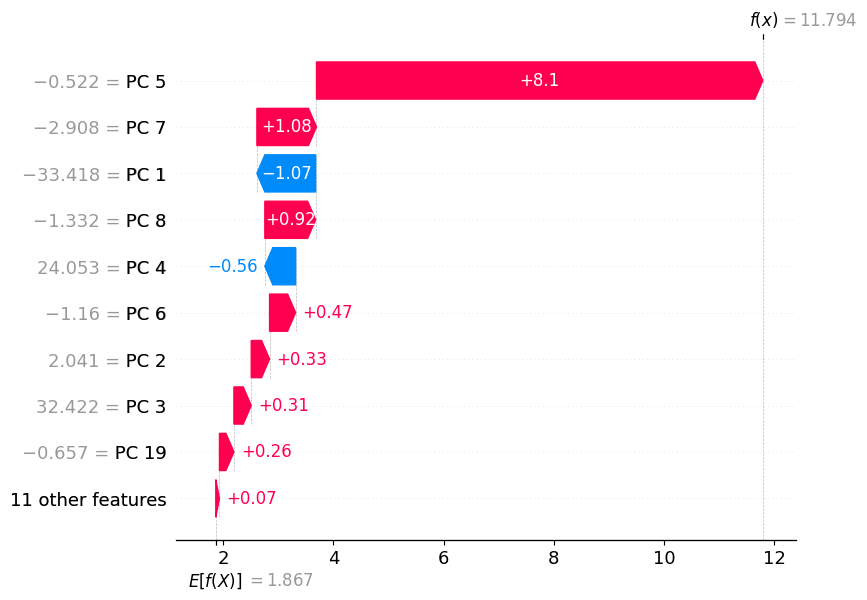

In [65]:
explainer = shap.Explainer(rf, X_test_shap)
shap_values = explainer(X_test_shap)
shap.plots.waterfall(shap_values[0])

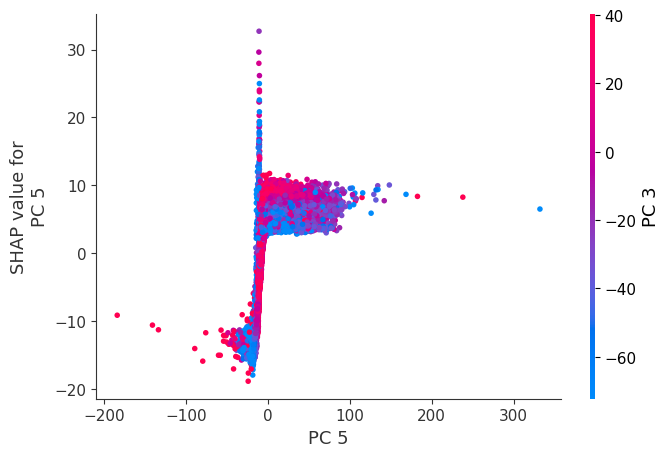

In [55]:
shap.dependence_plot("PC 5", shap_values, X_test_shap)

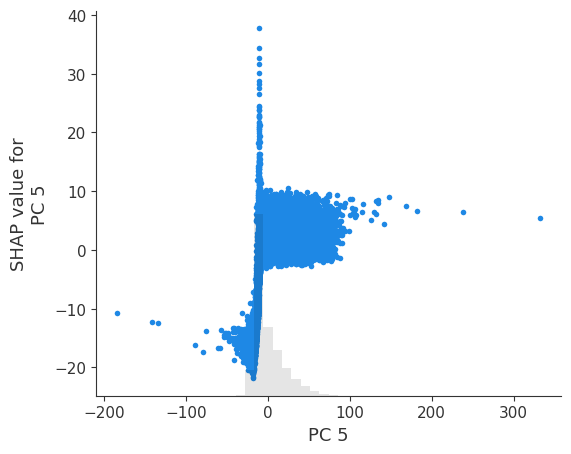

In [66]:
shap.plots.scatter(shap_values[:, "PC 5"])

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,...,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,weight,label
0,-49.165605,52.302100,40.330463,-20.025530,-10.050272,5.621220,2.006527,-2.064120,-5.841686,1.029164,...,0.111542,2.031526,-0.855737,0.295838,0.860626,-0.839075,-0.309392,0.506865,3.024684,numu
1,-71.218699,-5.388710,35.586905,30.767555,-11.013059,-0.613587,-0.432097,-0.847418,2.557928,2.597687,...,0.678816,1.944269,0.898076,-1.511303,-0.180979,-0.313097,-0.188450,0.385376,3.373481,numu
2,17.804211,7.604213,-87.111606,-68.512415,-18.664034,-5.879879,1.467604,1.158214,22.066755,-1.858302,...,-1.804633,-0.511565,0.337374,1.474101,-1.251476,-0.301963,-0.381262,-0.501788,0.276282,numu
3,-14.709687,32.974759,20.171739,15.318727,-10.333330,0.197013,-3.493777,-0.044876,-5.073138,-2.617921,...,3.866605,-1.967447,0.363797,0.199011,-1.293656,-1.000044,-0.635539,-0.513496,5.049469,numu
4,-8.039413,-33.919454,19.314678,35.384561,-12.383886,1.352567,-2.486127,0.603511,-3.650025,-2.510127,...,-0.762225,-0.310989,0.130779,0.260993,-0.128245,-0.835670,0.055543,0.142566,6.808881,numu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199969,287.124690,-89.272866,-27.290029,-4.970265,32.605288,-13.327157,5.415331,-7.803626,8.572794,0.084703,...,0.267545,-1.376871,0.337320,-0.066123,-0.748384,-1.283044,0.257745,-0.654212,0.026379,nutau
199970,-38.079852,-31.302254,23.801109,37.518153,7.632927,1.622527,-1.793059,-2.118853,-2.946080,-1.809208,...,1.640938,-1.097248,0.826895,0.176116,-0.547783,-0.378845,0.259038,-0.096578,0.076483,nutau
199971,-21.891955,-14.638016,-14.149773,3.585708,-9.925775,-3.057116,-0.962252,0.728806,0.010048,-1.932538,...,1.855304,-2.972638,-0.097767,1.075913,-0.439074,-0.088054,0.249285,-0.016737,0.056720,nutau
199972,-29.871782,-16.965120,-12.244586,-19.939861,51.078982,-12.996666,3.106250,-5.846021,10.547600,0.132978,...,-1.500048,0.901384,1.648075,-2.243180,-0.242170,0.358911,-0.139047,0.361396,0.019195,nutau


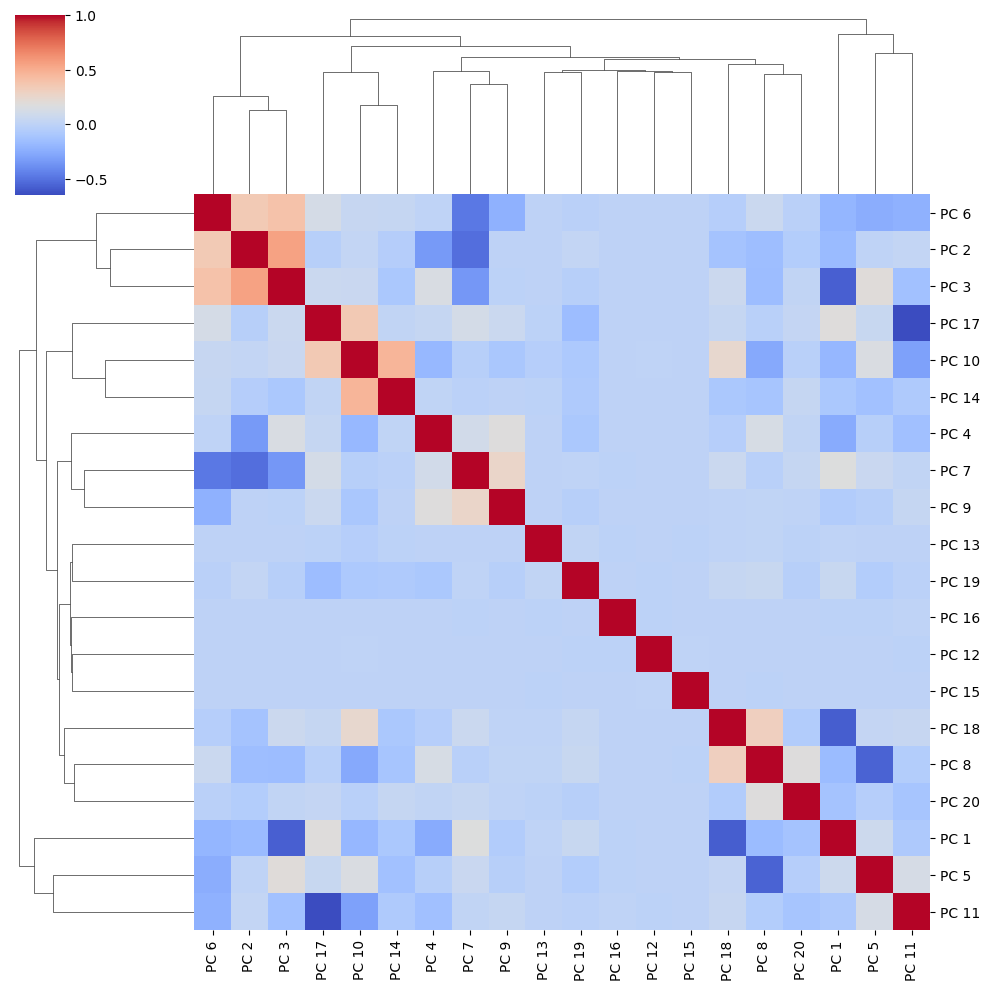

In [25]:
import seaborn as sns
X_df = pd.DataFrame(X_pca[:,:-1])
X_df.columns = [f"PC {i}" for i in range(1,21)]
corr_matrix = X_df.corr(method='spearman')
# fig, ax1 = plt.subplots(figsize = (8,8), dpi = 200)
res = sns.clustermap(corr_matrix, method='weighted', cmap='coolwarm')
plt.savefig('corr_matrix.pdf', format='pdf')
X_df["weight"] = X_pca[:,-1]
X_df["label"] = y.values
X_df

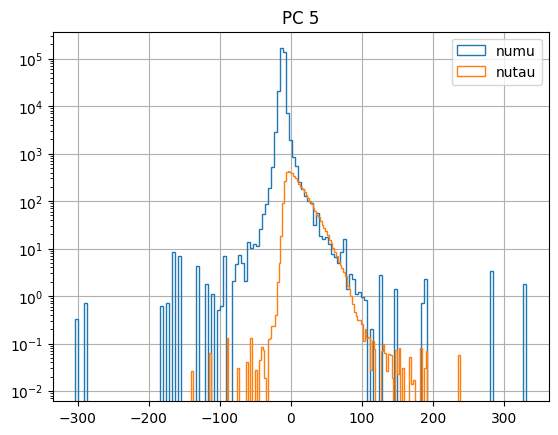

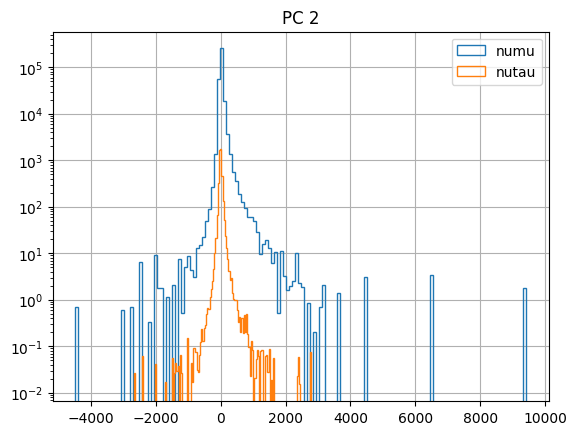

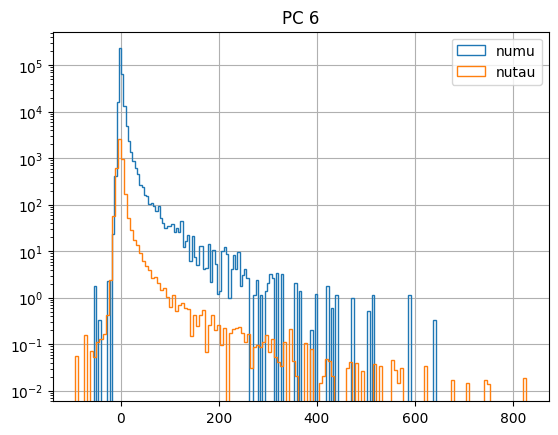

In [140]:
for i in [5,2,6]:
    feat = f"PC {i}"
    X_df_mu = X_df.loc[X_df["label"] == "numu"]
    X_df_tau = X_df.loc[X_df["label"] == "nutau"]
    fig, ax = plt.subplots()
    X_df_mu[feat].hist(bins = 150, 
                         weights = X_df_mu["weight"],
                         histtype = "step",
                         ax = ax, label = "numu")
    X_df_tau[feat].hist(bins = 150,
                          weights = X_df_tau["weight"], 
                          histtype = "step",
                          ax = ax, label = "nutau")
    ax.set_title(feat)
    ax.set_yscale("log")
    ax.legend()

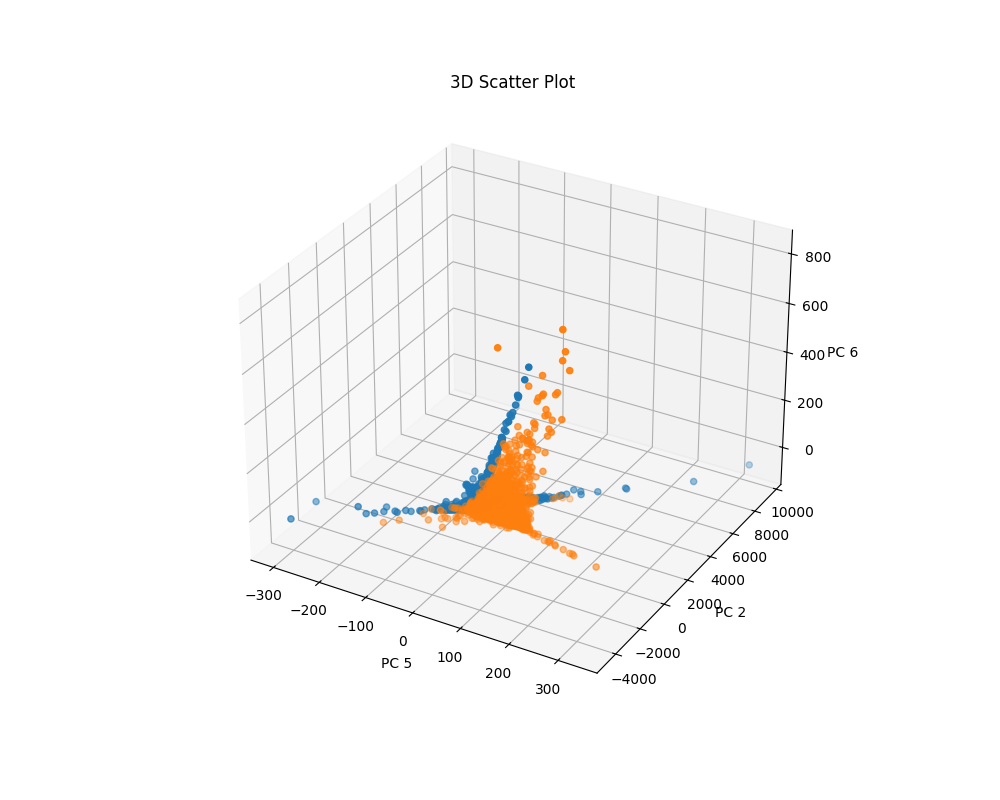

In [147]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have already defined X_df, y_train, par1, par2, and par3

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
X_df_mu = X_df.loc[X_df["label"] == "numu"]
X_df_tau = X_df.loc[X_df["label"] == "nutau"]
# Plot the scatter plot
ax.scatter(X_df_mu[par1], X_df_mu[par2], X_df_mu[par3], label = "numu")
ax.scatter(X_df_tau[par1], X_df_tau[par2], X_df_tau[par3], label = "nutau")

# Set labels and title
ax.set_xlabel(par1)
ax.set_ylabel(par2)
ax.set_zlabel(par3)
ax.set_title('3D Scatter Plot')

plt.show()

In [98]:
X_df.to_numpy()[:,:-1].shape

(199974, 11)

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object)

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
X_df_np = X_df.to_numpy()[:,:-1]
le = LabelEncoder()
le.fit(["numu", "nutau"])
y1 = le.transform(X_df.to_numpy()[:,-1])
y = X_df["label"].map({'numu':0,'nutau':1}).values
print(sum(y-y1))
X_train, X_test, y_train, y_test = train_test_split(
    X_df_np, y, random_state=13,  shuffle=True
)
scaler = StandardScaler()
weights_train = X_train[:,-1]
weights_test = X_test[:,-1]
X_train = scaler.fit_transform(X_train[:,:-1])
X_test = scaler.fit_transform(X_test[:,:-1])

# rf = RandomForestClassifier()
rf = lightgbm.LGBMClassifier()
rf.fit(X_train, y_train,
       sample_weight = weights_train
      )

alpha = 0.05
y_pred = rf.predict(X_test)
cor = accuracy_score(y_test, y_pred, sample_weight = weights_test)
print(cor)
boot_mat_score = bootstrap_metric(y_test, y_pred, weights_test, metric_fn=lambda x, y, w: f1_score(y_true=x, y_pred=y, sample_weight=w) , alpha = alpha)
print("Model: {0}".format("Random Forest"), " \t f1-score: ", np.quantile(boot_mat_score, q=[alpha/2, 1 - alpha/2]))



0
[LightGBM] [Info] Number of positive: 74861, number of negative: 75119
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 149980, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013479 -> initscore=-4.293016
[LightGBM] [Info] Start training from score -4.293016
0.9990900245800062


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [ ]:
fig = px.scatter_matrix(X_df,
    dimensions=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8', 'PC 9',
       'PC 10'], color="label", symbol="label")
#     ,
#     title="Scatter matrix of CCDIS",
#     labels=X_df.columns[:-1]) # remove underscore
fig.update_traces(diagonal_visible=False)
fig.update_layout(
    height=3000,  # set the height in pixels
    width=3000    # set the width in pixels
)
# fig.write_image("scatter.pdf")
fig.show()

In [77]:
# Extract the three largest values from the column
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC {i + 1}' for i in range(pca.n_components_)], index=X.columns)
top_three_values_pc1 = loadings.nlargest(3, "PC 1")["PC 1"]
top_three_values_pc2 = loadings.nlargest(3, "PC 2")["PC 2"]


ValueError: Shape of passed values is (20, 20), indices imply (29, 20)

20.576270643471485 -23.08573879399258
4.2428302631858195 -10.177082759321047


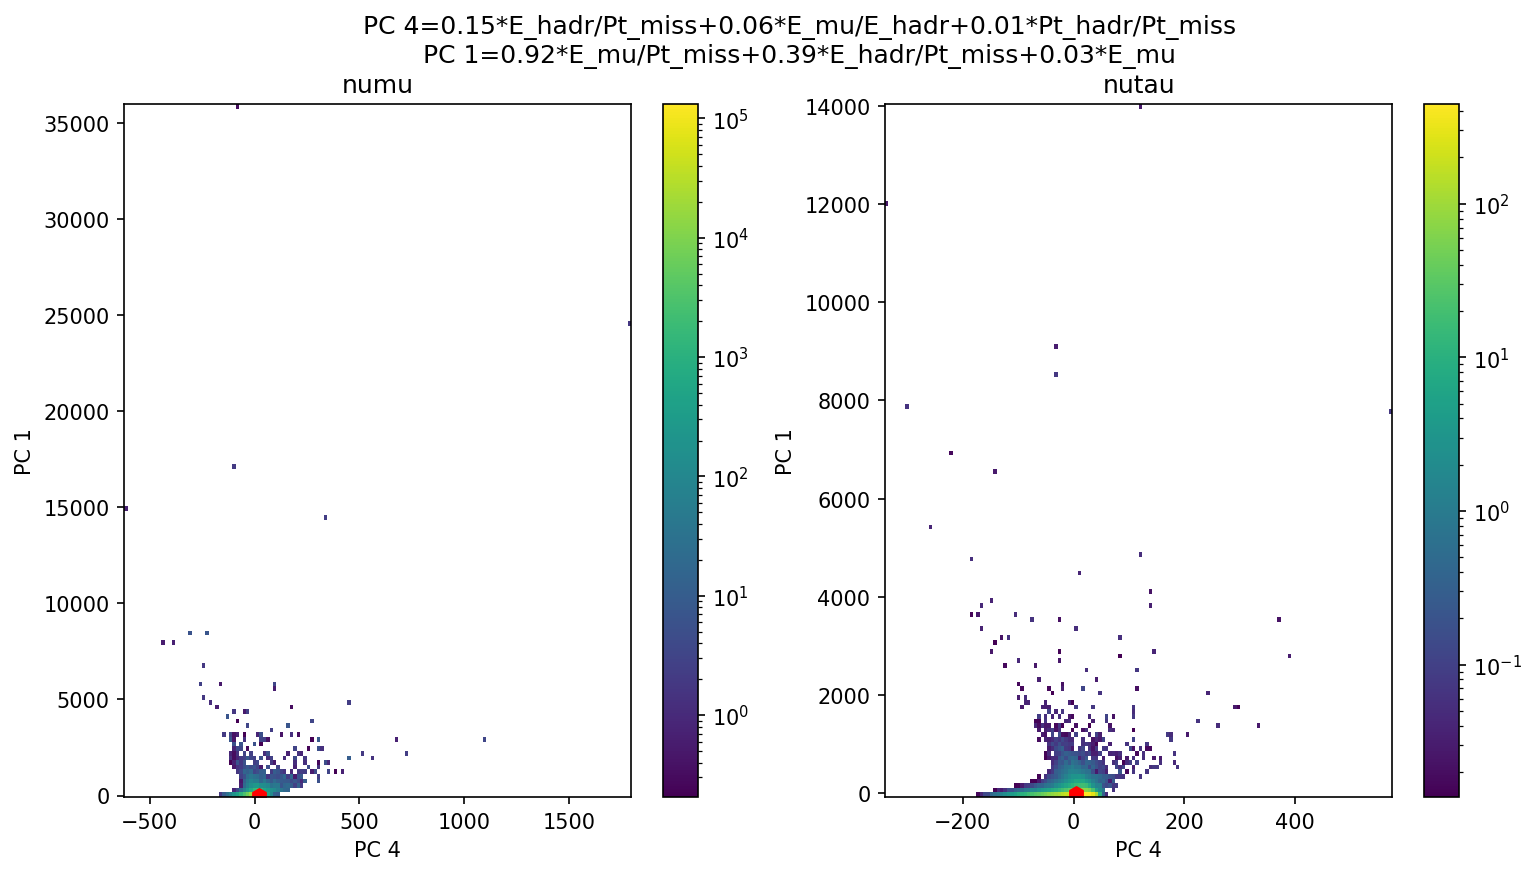

In [29]:
import matplotlib as mpl
from sklearn.utils.extmath import weighted_mode
def prepare_formula(var, top_three_values_pc):
    var_names = list(map(str, top_three_values_pc.index))
    var_vals = top_three_values_pc.to_numpy()
    output_str = var + "="
    k = 0
    for val, name in zip(var_vals, var_names):
        output_str += f"{val:.2f}*{name}"
        if k != 2:
            output_str += "+"
        k += 1 
    return output_str
par1 = "PC 4"
par2 = "PC 1"
fig, ax = plt.subplots(1,2, figsize = (12,6), dpi = 150)
X_df_mu = X_df.query("label == 'numu'")
X_df_tau = X_df.query("label == 'nutau'")
#X_df_mu = X_df_mu.loc[((X_df_mu[par1] > -20) & (X_df_mu[par1] < 50)) & ((X_df_mu[par2] > -20) & (X_df_mu[par2] < 50))]
#X_df_tau = X_df_tau.loc[((X_df_tau[par1] > -20) & (X_df_tau[par1] < 50)) & ((X_df_tau[par2] > -20) & (X_df_tau[par2] < 50))]
h = ax[0].hist2d(X_df_mu[par1], X_df_mu[par2], weights = X_df_mu["weight"], bins = 150, norm=mpl.colors.LogNorm())
x_mean, y_mean = sum(X_df_mu[par1].values*X_df_mu["weight"].values)/sum(X_df_mu["weight"].values), sum(X_df_mu[par2].values*X_df_mu["weight"].values)/sum(X_df_mu["weight"].values)
#x_mod, y_mod = weighted_mode(X_df_mu[par1].values, X_df_mu["weight"].values), weighted_mode(X_df_mu[par2].values, X_df_mu["weight"].values)

# x_std, y_std = sum((X_df_tau[par1].values-[x_mean]*len(X_df_tau[par1].values))
print(x_mean, y_mean)
#print(x_mod, y_mod)
ax[0].scatter([x_mean], [y_mean], s = 5 * 10, marker = "h", color = "red")
#ax[0].scatter([x_mod[0][0]], [y_mod[0][0]], s = 5 * 10, marker = "h", color = "orange")
ax[0].set_xlabel(par1)
ax[0].set_ylabel(par2)
# ax[0].set_xlim([-20, 50])
# ax[0].set_ylim([-20, 50])
fig.colorbar(h[3], ax = ax[0])
h = ax[1].hist2d(X_df_tau[par1], X_df_tau[par2], weights = X_df_tau["weight"], bins = 150, norm=mpl.colors.LogNorm())
x_mean, y_mean = sum(X_df_tau[par1].values*X_df_tau["weight"].values)/sum(X_df_tau["weight"].values), sum(X_df_tau[par2].values*X_df_tau["weight"].values)/sum(X_df_tau["weight"].values)
#x_mod, y_mod = weighted_mode(X_df_tau[par1].values, X_df_tau["weight"].values), weighted_mode(X_df_tau[par2].values, X_df_tau["weight"].values)
print(x_mean, y_mean)
#print(x_mod, y_mod)
ax[1].scatter([x_mean], [y_mean], s = 5 * 10, marker = "h", color = "red")
#ax[1].scatter([x_mod[0][0]], [y_mod[0][0]], s = 5 * 10, marker = "h", color = "orange")
ax[1].set_xlabel(par1)
ax[1].set_ylabel(par2)
# ax[1].set_xlim([-20, 50])
# ax[1].set_ylim([-20, 50])
ax[0].set_title("numu")
ax[1].set_title("nutau")
fig.suptitle(prepare_formula(par1, top_three_values_pc1) + "\n" + prepare_formula(par2, top_three_values_pc2))
fig.colorbar(h[3], ax = ax[1])

In [248]:
X_df.loc[:,~X_df.columns.isin(["label"])]

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,...,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,weight
0,-0.636012,0.339132,-2.924003,1.035065,-0.165804,0.018562,1.249850,0.613687,-0.219046,-0.765499,...,-0.806262,-0.816534,0.026803,-0.444665,0.122046,0.182678,-0.149619,-0.057498,0.458447,3.024684
1,1.469869,-1.314517,-2.336944,0.962480,-0.131565,0.403704,-1.041680,1.190332,-0.265590,0.415235,...,0.324081,0.683071,0.086797,-0.308657,0.101396,-0.300572,-0.195408,0.333711,0.319315,3.373481
2,0.557960,4.713739,0.282483,-2.713065,-0.334457,1.501444,-3.875804,-1.355264,1.286039,0.795861,...,0.418109,-0.151154,-0.772220,0.310608,0.148464,-0.213739,-0.104565,-0.195230,-0.070639,0.276282
3,-1.500434,0.427382,0.853887,0.832324,-0.436974,-2.427793,-0.745204,1.561242,-0.484249,0.420419,...,0.407003,1.089476,-2.001234,-0.083659,0.021625,-0.069763,0.226241,-0.278005,-0.041113,5.049469
4,0.845599,-0.652748,0.487825,1.417047,-0.703743,0.462359,1.614801,-0.149395,-0.525898,0.178975,...,-0.047257,0.395112,-1.037215,-0.257524,0.082973,0.092478,0.180535,-0.176448,0.095334,6.808881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199969,-0.152610,0.783319,3.596572,0.533701,0.236851,-1.145430,1.588686,-0.641212,0.548785,0.341196,...,1.002074,-0.391020,-0.265306,-0.373616,-0.116268,0.529671,-0.703970,0.570788,-0.586490,0.026379
199970,-0.231979,-1.851088,1.307191,0.923593,-0.534030,-1.197894,0.025925,0.508281,-0.400449,0.809240,...,-0.109053,0.688844,-0.687291,-0.068822,-0.111556,0.173233,0.036809,0.162930,-0.151810,0.076483
199971,-0.851429,-0.063005,1.790778,-0.177674,-0.538891,-1.259027,-1.654482,0.174628,0.241772,0.271742,...,0.666649,0.089545,-0.836085,0.428538,0.224616,-0.090288,0.361474,0.227813,0.026134,0.056720
199972,-1.495944,-0.456545,1.218039,-1.637998,0.134784,0.321740,0.961848,-1.110747,-0.001952,0.897736,...,0.350328,0.396700,1.481643,-0.358433,-0.743314,0.274934,-0.705495,-0.351171,0.059566,0.019195


In [ ]:
import plotly.express as px
X_train, X_test, y_train, y_test = train_test_split(
    X_df.loc[:,~X_df.columns.isin(["label"])], X_df["label"].values, random_state=13,  shuffle=True, train_size = 0.1
)
par1 = "PC 5"
par2 = "PC 2"
par3 = "PC 6"
scaleFactor = np.array([10]*len(y_train))
marker_size = scaleFactor  # You can adjust scaleFactor to control the marker size
symbol_mapping = {value: symbol for value, symbol in zip(np.unique(y_train), ["square", "circle"])}
marker_symbol = [symbol_mapping[value] for value in y_train]

fig = px.scatter_3d(x=X_train[par1], y=X_train[par2], z=X_train[par3], color=y_train, size=marker_size, symbol=marker_symbol)

# label_mapping = {value: label for value, label in zip(y_train.unique(), y_train.unique())}
# trace_name = [label_mapping[value] for value in y_train]
fig.update_layout(
    height=1000,  # set the height in pixels
    width=1000,   # set the width in pixels
    scene=dict(
        xaxis_title=par1,
        yaxis_title=par2,
        zaxis_title=par3,
        xaxis=dict(range=[-50, 100]),
        yaxis=dict(range=[-500, 500]),
        zaxis=dict(range=[-50, 50])
    )
)
fig.write_html("3pca.html")
fig.show()



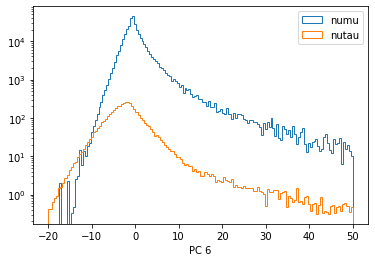

In [37]:
fig, ax = plt.subplots()
ax.hist(X_df_mu[par1], bins = 150, weights = X_df_mu["weight"], histtype = "step", label = "numu")
ax.hist(X_df_tau[par1], bins = 150, weights = X_df_tau["weight"], histtype = "step", label = "nutau")
ax.set_yscale("log")
ax.set_xlabel(par1)
ax.legend()

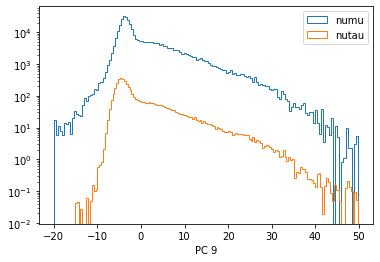

In [38]:
fig, ax = plt.subplots()
ax.hist(X_df_mu[par2], bins = 150, weights = X_df_mu["weight"], histtype = "step", label = "numu")
ax.hist(X_df_tau[par2], bins = 150, weights = X_df_tau["weight"], histtype = "step", label = "nutau")
ax.set_yscale("log")
ax.set_xlabel(par2)
ax.legend()

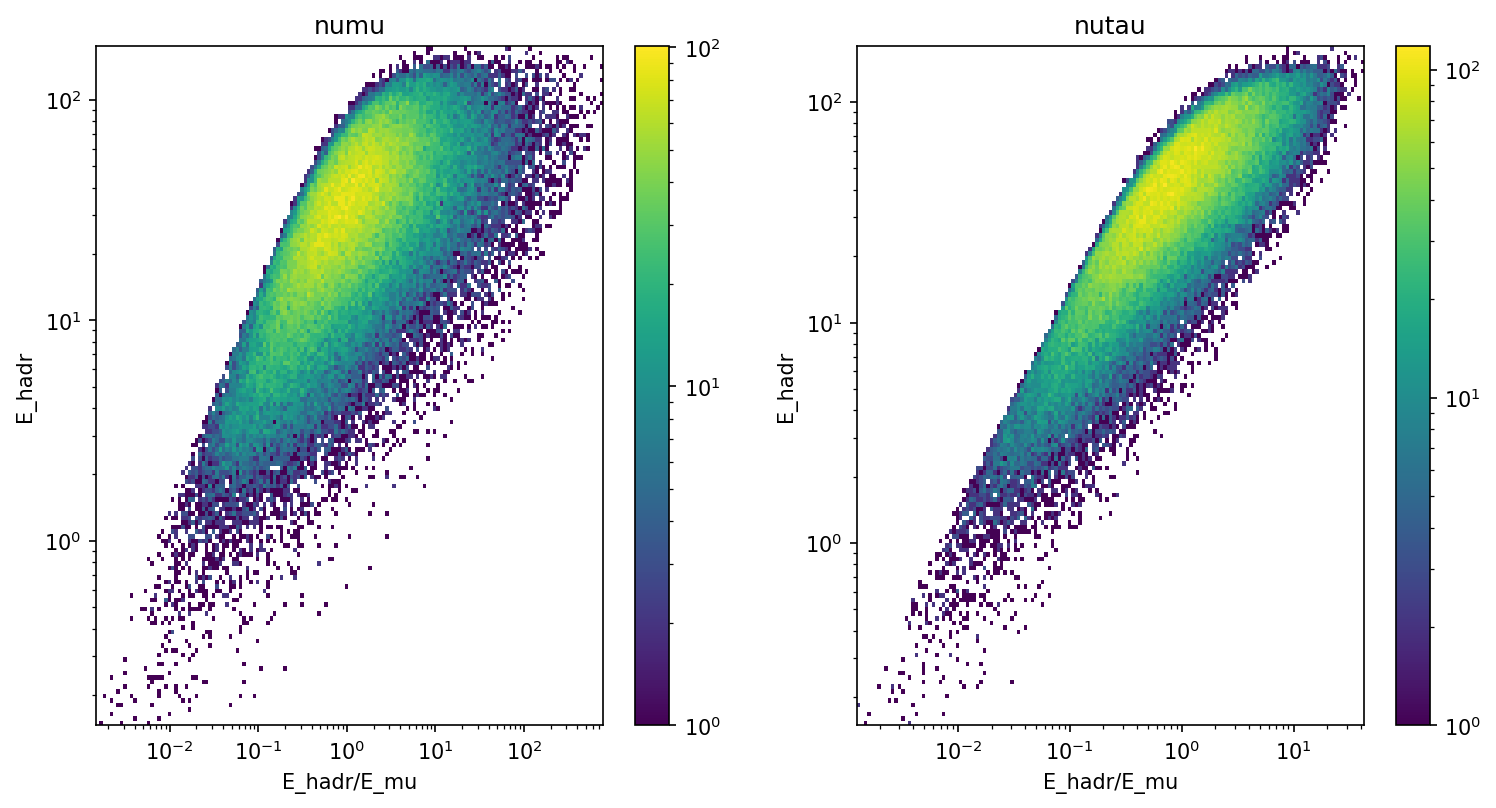

In [105]:
import matplotlib as mpl
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

X_df_mu = df_muon_1.query("label == 'numu'")
X_df_tau = df_muon_1.query("label == 'nutau'")

# Logarithmically spaced bins
log_binsx = np.logspace(np.log10(X_df_mu["E_hadr/E_mu"].min()), np.log10(X_df_mu["E_hadr/E_mu"].max()), 150)
log_binsy = np.logspace(np.log10(X_df_mu["E_hadr"].min()), np.log10(X_df_mu["E_hadr"].max()), 150)
#log_binsx, log_binsy = 150, 150
h = ax[0].hist2d(X_df_mu["E_hadr/E_mu"], X_df_mu["E_hadr"], bins=[log_binsx, log_binsy], norm=mpl.colors.LogNorm())
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("E_hadr/E_mu")
ax[0].set_ylabel("E_hadr")
fig.colorbar(h[3], ax=ax[0])
log_binsx = np.logspace(np.log10(X_df_tau["E_hadr/E_mu"].min()), np.log10(X_df_tau["E_hadr/E_mu"].max()), 150)
log_binsy = np.logspace(np.log10(X_df_tau["E_hadr"].min()), np.log10(X_df_tau["E_hadr"].max()), 150)
#log_binsx, log_binsy = 150, 150
h = ax[1].hist2d(X_df_tau["E_hadr/E_mu"], X_df_tau["E_hadr"], bins=[log_binsx, log_binsy], norm=mpl.colors.LogNorm())
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel("E_hadr/E_mu")
ax[1].set_ylabel("E_hadr")
fig.colorbar(h[3], ax=ax[1])
ax[0].set_title("numu")
ax[1].set_title("nutau")
plt.show()


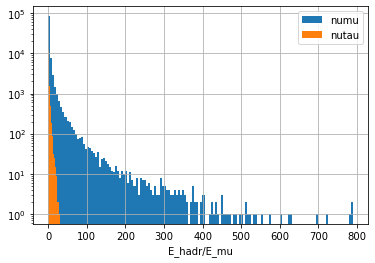

In [104]:
fig, ax = plt.subplots()
X_df_mu["E_hadr/E_mu"].hist(bins = 150, ax = ax, label = "numu")
X_df_tau["E_hadr/E_mu"].hist(bins = 150, ax = ax, label = "nutau")
ax.set_yscale("log")
ax.set_xlabel("E_hadr/E_mu")
ax.legend()

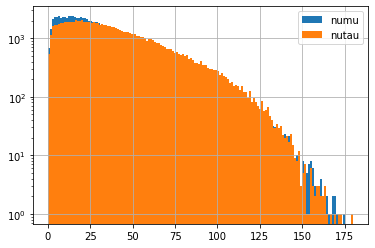

In [94]:
fig, ax = plt.subplots()
X_df_mu["E_hadr"].hist(bins = 150, ax = ax, label = "numu")
X_df_tau["E_hadr"].hist(bins = 150, ax = ax, label = "nutau")
ax.set_yscale("log")
ax.legend()

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred, sample_weight=weights_test)
print("Accuracy:", accuracy)

Accuracy: 0.9987166231707787


In [131]:
# f1 score. Bootstrap
from sklearn.metrics import average_precision_score, matthews_corrcoef, f1_score
def bootstrap_metric(x, 
                     y,
                     w,
                     metric_fn,
                     samples_cnt = 100,
                     alpha = 0.05,
                     random_state = 42):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        w_boot = w[poses]
        
        m_val = metric_fn(x_boot, y_boot, w_boot)
        b_metric[it] = m_val
        if it%10 == 0:
            print(it, "...")
    
    return b_metric
alpha = 0.05
y_pred = rf.predict(X_test)
cor = accuracy_score(y_test, y_pred)
boot_mat_score = bootstrap_metric(y_test, y_pred, weights_test, metric_fn=lambda x, y, w: matthews_corrcoef(y_true=x, y_pred=y, sample_weight=w) , alpha = alpha)
print("Model: {0}".format("Random Forest"), " \t f1-score: ", np.quantile(boot_mat_score, q=[alpha/2, 1 - alpha/2]))

0 ...
10 ...
20 ...
30 ...
40 ...
50 ...
60 ...
70 ...
80 ...
90 ...
Model: Random Forest  	 f1-score:  [0.95267939 0.97906672]


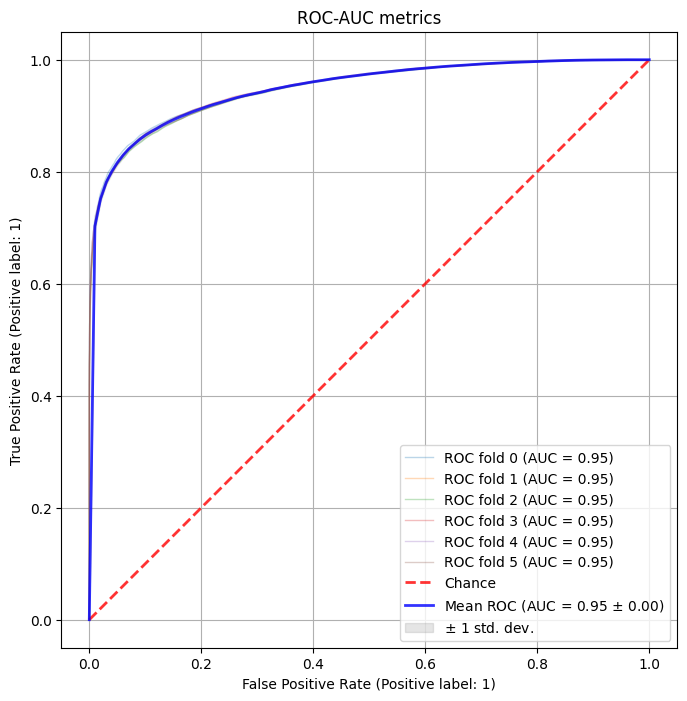

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, RocCurveDisplay
import numpy as np 
import matplotlib.pyplot as plt

# Assuming X_scaled and y0 are defined
# X_scaled = ...
# y0 = ...
X_scaled, y0 = X_pca, df_muon_1["label"].map({'numu':0,'nutau':1}).values
# Create an example RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
plt.grid()

for i, (train, test) in enumerate(cv.split(X_scaled, y0)):
    # Use the last column of X_scaled as weights
    weights_train = X_scaled[train, -1]

    # Fit the model with sample weights
    model.fit(X_scaled[train, :-1], y0[train], sample_weight=weights_train)

    # Plot ROC curve
    viz = RocCurveDisplay.from_estimator(
        model,
        X_scaled[test, :-1],
        y0[test],
        sample_weight=X_scaled[test, -1],  # Use weights for test set
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# Plot mean ROC curve
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

# Plot standard deviation
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

# Set plot properties
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC-AUC metrics",
)
ax.legend(loc="lower right")
plt.show()


In [ ]:
fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='sepal length',
                                 values=df['sepal length']),
                            dict(label='sepal width',
                                 values=df['sepal width']),
                            dict(label='petal length',
                                 values=df['petal length']),
                            dict(label='petal width',
                                 values=df['petal width'])],
                diagonal_visible=False, # remove plots on diagonal
                text=df['class'],
                marker=dict(color=index_vals,
                            showscale=False, # colors encode categorical variables
                            line_color='white', line_width=0.5)
                ))


fig.update_layout(
    title='Iris Data set',
    width=600,
    height=600,
)

fig.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier

rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train, sample_weight = weights_train)

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

In [46]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred, sample_weight = weights_test)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

NameError: name 'best_rf' is not defined

In [ ]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, sample_weight = weights_test)
precision = precision_score(y_test, y_pred, sample_weight = weights_test)
recall = recall_score(y_test, y_pred, sample_weight = weights_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

In [ ]:
import numpy as np

perplexity = np.arange(5, 55, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(X_train)
    divergence.append(model.kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

In [ ]:
X_train_tsne_list = []
perp_list = [50]
for perp in perp_list:
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
    X_train_tsne_list.append(tsne.fit_transform(X_train))

In [ ]:
for i,X_train_tsne in enumerate(X_train_tsne_list):
    fig = px.scatter(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], color=y_train)
    fig.update_layout(
        title=f"t-SNE visualization. {perp_list[i]} of perplexity",
        xaxis_title="First t-SNE parameter",
        yaxis_title="Second t-SNE parameter",
    )
    fig.update_layout(
        height=1000,  # set the height in pixels
        width=1000    # set the width in pixels
    )
    fig.write_image(f"tSNE_{i}.png")
#     fig.write_image("tSNE.pdf")
    fig.show()

In [ ]:
import plotly.express as px 
fig = px.scatter_matrix(df_muon, dimensions=df_muon.columns, color=y)
fig.update_layout(
    height=2000,  # set the height in pixels
    width=2000    # set the width in pixels
)
fig.write_image("corr.pdf")
fig.show()

In [ ]:
!python -m pip install kaleido

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%reload_ext autoreload

In [ ]:
!pip install plotly>=4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O orca
!chmod +x orca

In [ ]:
X_train_tsne_vis = X_train_tsne[:100]
y_train_vis = y_train[:100]
fig = px.scatter_3d(x=X_train_tsne_vis[:, 0], y=X_train_tsne_vis[:, 1], z=X_train_tsne_vis[:, 2], color=y_train_vis, opacity=0.9)
fig.show()

In [ ]:
import umap
umap_2d = umap.UMAP()
proj_2d = umap_2d.fit_transform(X_train)

In [ ]:
fig_2d = px.scatter(proj_2d, x = 0, y = 1, color=y_train)
fig_2d.update_layout(
    height=1000,  # set the height in pixels
    width=1000    # set the width in pixels
)
fig_2d.update_layout(
    title="UMAP visualization",
    xaxis_title="First UMAP parameter",
    yaxis_title="Second UMAP parameter",
)
fig_2d.write_image("UMAP.pdf")
fig_2d.show()